In [1]:
import numpy as np
import pandas as pd
import sklearn.metrics as sk
import scipy 
import igraph
import ts2vg # Time series to visibility graphs
import scipy.spatial.distance as distance
import scipy
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.linear_model import LinearRegression
import os 

# Classes e Funções

In [4]:
def teste_hipotese(x,y,alfa):
    
    
    '''T-test hypothesis testing for regression. Returns 1 if null Hypthotesis can be rejected 
    (considering the chosen alfa ) and 0 if it can't.
    
    Parameters:
    -------------------------------------------
    x and y: Variables 
    alfa: Desired statistical significance.'''
    
    n = len(x)
    xmed = np.sum(x)/n;
    ymed = np.sum(y)/n;
    i = 0
    ttable = 1.960
    reject=0       
    reject0=0     
    Sxy = 0
    Sxx = 0 
    Syy = 0
    for i in range(n):
        Sxy = Sxy + ((x[i]-xmed)*(y[i]-ymed))
        Sxx = Sxx + np.power(x[i]-xmed, 2)

    b1 = Sxy/Sxx
    b0 = ymed-b1*xmed

    for i in range(n):
        Syy = Syy + np.power(y[i]-ymed, 2)

    R2 = np.power(Sxy,2)/(Sxx*Syy)
    R2a = 1 - ((n-1)/(n-2))*(1-R2)
    QME = (Syy-(b1*Sxy))/(n-2)
    bla = (1.0/n) + (xmed*xmed)/(Sxx)
    t0 = b0 / np.sqrt(QME*bla)
    t = b1 / np.sqrt(QME/Sxx)
    
    pvalue = 2*(1 - scipy.stats.t.cdf(np.abs(t),df=n-2))
    if np.abs(pvalue)<=alfa:
        reject=1
    else:
        reject=0
    
    return (reject,pvalue,t)

def heterogeinity(degree):
    power_degree = [] # degree sequence 
    for i in degree:
        power_degree.append(i**2)
        hp = ( (sum(power_degree)/len(power_degree))/((sum(degree)/len(degree))**2) )
    return(hp)

def geographical_distance(adj,pos):
    """
    Parameters:
    -----------
        adj - pares de pontos que correspondem a um ponto (série temporal) disposta no espaço geográfico da 
        bacia do rio Tamanduateí.
        pos - índice (d,j) de cada ponto na matriz que representa o espaço geográfico.
        
    Returns:
    --------
        A distância euclidiana entre os pontos distribuídos na região analisada.
    """
    geo_dist = {}
    for i in adj: # i é o par formado pelos grafos 'a' e 'b'
        a = pos[i[0]] # busca as coordenadas (i,j) do grafo 'a' no vetor que guarda a posição das séries na matriz
        b = pos[i[1]] # busca as coordenadas (i,j) do grafo 'b' no vetor que guarda a posição das séries na matriz
        dist = np.sqrt((a[0]-b[0])**2+(a[1]-b[1])**2)
        geo_dist[i] = dist
    return(geo_dist)

def norm(data,dataType):
    """
    Parameters:
    -----------
        data: Lista ou dicionário
        dataType: Informa se o dado é do tipo lista (0), ou do tipo dicionário (1)
    
    Returns:
    --------
        Valores do vetor data entre o intervalo de 0 e 1.
    
    """
    if (dataType == 0):
        n = [];
        max_value = max(data);
        min_value = min(data);
        for i in range(len(data)):
            n.append((data[i]-min_value)/(max_value - min_value));
    else:
        n = {};
        max_value = max(list(data.values()));
        min_value = min(list(data.values()));
        for i in data:
            n[i] = (data[i]-min_value)/(max_value - min_value);
            
    return(n)

class reading():
    
    def files_and_validation():
        """
        Returns:
        --------
            Realiza a leitura dos arquivos contendo as matrizes de dados. Os dados inválidos das matrizes (-99) são
            removidos, gerando vetores com apenas os valores válidos.
            data ==> Vetor contendo apenas os valores válidos das matrizes
            pos ==> Vetor contendo a posição que os valores válidos ocupam na matriz de dados original
        """
        files_list = os.listdir('data-01-original');
        files_list.sort();
        data = [];
        for i in range(len(files_list)):
            m = np.genfromtxt('data-01-original/'+str(files_list[i]));
            validated = [];
            pos = [];
            for row in range(len(m[:,0])):
                for column in range(len(m[0,:])):
                    if (m[row][column] != -99):
                        validated.append(m[row,column]);
                        pos.append([row,column]);
            data.append(validated);
                    
        return(data,pos);

    def timeSeriesGeneration(validated_data):
        """
        Parameters:
        -----------
            Arrays unidimensionais contendo os valores estimados das previsões
        Returns:
        --------
            Série temporal associada a cada ponto válido (diferente de -99).
            A série temporal 0 será composta por todos os valores na posição 0 dos 4464 arrays, e assim
            em diante. O resultado são 587 séries temporais de tamanho 4464.
        """
        time_series = {};
        for i in range(len(validated_data[0])):
            s = np.empty((0,0));
            for j in range(len(validated_data)):
                s = np.append(s,validated_data[j][i]);
            time_series[i] = s;
        
        for t in range(len(time_series)):
            for k in range(len(time_series[0])):
                if (time_series[t][k] < 20):
                    time_series[t][k] = 0;
                
        return(time_series);

class network():

    def unweighted_graphs(data):
        """
        Parameters:
        -----------
            Lista de valores inteiros que correspondem aos nós de uma rede. Os valores devem ser conectados
            em sequência.
            Exemplo:
                data = (1,2,8,4,5,2,7,9,4)
                adjacency_list from data: (1,2),(2,8),(8,4),(4,5),(5,2),(2,7),(7,9),(9,4)
            Assim, um grafo seria construído usando o conjunto data como os nós da rede e o conjunto
            adjacency_list seria responsável pela conexão dos nós.
            Os pares repetidos na lista de adjacência irão contabilizar os pesos. Se um par de conexão se
            repete 5 vezes, por exemplo, então o peso desse link é 5.
        
        Returns:
        --------
            1. all_metrics - Dicionário contendo as medidas average degree, average betweenness,
            average closeness, density e diameter.
            2. seq_metrics - Dicionário contendo 587 índices (587 grafos). Cada índice possui outro dicionário
            com as sequências de valores de degree, betweenness e closeness.
            3. global_metrics - Dicionário contendo as métricas assortativity degree, heterogeinity parameter,
            density e diameter para todos os grafos.
            4. local_metrics - Dicionário contendo as médias de betweenness, degree e closeness.
        """

        # Graph creation from decimal integer array

        graph = igraph.Graph()

        #graph.add_vertices(max(data)+1)
        graph.add_vertices(len(data))

        #adjacency_list = np.empty((0,0), int)
        adj_list = []

        for i in range(len(data)):
            if not(len(data)-1 == i):
                adj_list.append([data[i],data[i+1]])
        
        # sorting
        for i in range(len(adj_list)):
            adj_list[i].sort()        
        
        # Removing duplicates
        adj_list = np.array(adj_list)
        adj_list = np.unique(adj_list, axis=0)
        
        for i in range(len(data)):
            graph.vs[i]["label"] = i

        graph.add_edges(adj_list) # Full graph, with disconnected nodes
        
        # Only nodes with degree > 0

        disconnected = np.empty((0,0), int)
        for i in range(graph.vcount()):
            if (graph.vs[i].degree() == 0):
                disconnected = np.append(disconnected, i)

        graph.delete_vertices(disconnected)
        
        all_u_metrics, seq_u_metrics, global_u_metrics, local_u_metrics = network.unweighted_metrics(graph)
        
        return(all_u_metrics, seq_u_metrics, global_u_metrics, local_u_metrics)
    
    def weighted_graphs(data):
    
        # Graph creation from decimal integer array

        graph = igraph.Graph()

        #graph.add_vertices(max(data)+1)
        graph.add_vertices(len(data))

        #adjacency_list = np.empty((0,0), int)
        aux_list = []
        adjacency_list = []
        weights = []
        edge_weight = {}

        for i in range(len(data)):
            if not(len(data)-1 == i):
                aux_list.append([data[i],data[i+1]])
        
        # sorting
        for i in range(len(aux_list)):
            aux_list[i].sort()
        
        # Counting repetitions
        for i in range(len(aux_list)):
            weights.append(aux_list.count(aux_list[i]))
        
        # keys: pair of edges
        # value: weights
        for i in range(len(aux_list)):
            edge_weight[aux_list[i][0],aux_list[i][1]] = weights[i]
        
        for i in range(len(data)):
            graph.vs[i]["label"] = i

        graph.add_edges(list(edge_weight.keys())) # Full graph, with disconnected nodes
        
        graph.es['weight'] = list(edge_weight.values()) # Weight list based on how many times a pair of edges occurs

        # Only nodes with degree > 0

        disconnected = np.empty((0,0), int)
        for i in range(graph.vcount()):
            if (graph.vs[i].degree() == 0):
                disconnected = np.append(disconnected, i)

        graph.delete_vertices(disconnected)
        
        all_w_metrics, seq_w_metrics, global_w_metrics, local_w_metrics = network.weighted_metrics(graph)
        
        return(all_w_metrics, seq_w_metrics, global_w_metrics, local_w_metrics)    
        
    def unweighted_metrics(g):
        """
        Parameters:
        -----------
            Grafo criado na biblioteca igraph
            
        Returns:
        --------
            1. feature_dict - Dicionário contendo as medidas average degree, average betweenness,
            average closeness, density e diameter.
            2. seq_dict - Dicionário contendo 587 índices (587 grafos). Cada índice possui outro dicionário
            com as sequências de valores de degree, betweenness e closeness.
            3. feature_global_dict - Dicionário contendo as métricas assortativity degree, heterogeinity parameter,
            density e diameter para todos os grafos.
            4. feature_local_dict - Dicionário contendo as médias de betweenness, degree e closeness.           
        """
        
        # Degree and Average degree
        degree_sequence = [round(i,4) for i in g.degree()]
        avg_degree = sum(degree_sequence)/len(degree_sequence)
    
        # Diameter
        diameter = round(g.diameter(),4)

        # Betweenness and Average Betweenness
        betweenness_sequence = [round(i,4) for i in g.betweenness()]
        avg_betweenness = round((sum(betweenness_sequence)/len(betweenness_sequence)),4)

        # Closeness and Average Closeness
        closeness_sequence = [round(i,4) for i in g.closeness()]
        avg_closeness = round(sum(closeness_sequence)/len(closeness_sequence),4)

        # Density
        density = round(g.density(loops=True),4)

        # Heterogeinity parameter
        hp = round(heterogeinity(g.degree()),4)
            
        u_feature_dict = {
                'Avg_Betweenness': avg_betweenness,
                'Avg_Closeness': avg_closeness,
                'Avg_Degree': avg_degree,
                'Diameter': diameter,
                'Density': density
        }

        u_seq_dict = {
                'Betweenness': betweenness_sequence,
                'Closeness': closeness_sequence,
                'Degree': degree_sequence,
        }

        u_feature_global_dict = {
                'heterogeneity_Parameter': hp,
                'Density': density,
                'Diameter': diameter
        }

        u_feature_local_dict = {
                'Avg_Betweenness': avg_betweenness,
                'Avg_Closeness': avg_closeness,
                'Avg_Degree': avg_degree
        }
                
        return(u_feature_dict,u_seq_dict,u_feature_global_dict,u_feature_local_dict)
    
    def weighted_metrics(g):
        """
        Parameters:
        -----------
            Grafo criado na biblioteca igraph
            
        Returns:
        --------
            1. feature_dict - Dicionário contendo as medidas average degree, average betweenness,
            average closeness, density e diameter.
            2. seq_dict - Dicionário contendo 587 índices (587 grafos). Cada índice possui outro dicionário
            com as sequências de valores de degree, betweenness e closeness.
            3. feature_global_dict - Dicionário contendo as métricas assortativity degree, heterogeinity parameter,
            density e diameter para todos os grafos.
            4. feature_local_dict - Dicionário contendo as médias de betweenness, degree e closeness.           
        """
        
        # Strength and Average strength
        strength_sequence = [round(i,4) for i in g.strength(weights=g.es['weight'])]
        avg_strength = sum(strength_sequence)/len(strength_sequence)
    
        # Diameter
        diameter = round(g.diameter(weights=g.es['weight']),4)

        # Betweenness and Average Betweenness
        betweenness_sequence = [round(i,4) for i in g.betweenness(weights=g.es['weight'])]
        avg_betweenness = round((sum(betweenness_sequence)/len(betweenness_sequence)),4)

        # Closeness and Average Closeness
        closeness_sequence = [round(i,4) for i in g.closeness(weights=g.es['weight'])]
        avg_closeness = round(sum(closeness_sequence)/len(closeness_sequence),4)

        # Density
        density = round(g.density(loops=True),4)        
        
        # Heterogeinity parameter
        hp = heterogeinity(strength_sequence) # ??
            
        w_feature_dict = {
                'Avg_Betweenness': avg_betweenness,
                'Avg_Closeness': avg_closeness,
                'Avg_Strength': avg_strength,
                'Diameter': diameter
        }

        w_seq_dict = {
                'Betweenness': betweenness_sequence,
                'Closeness': closeness_sequence,
                'Strength': strength_sequence
        }

        w_feature_global_dict = {
                'heterogeneity_Parameter': hp,
                'Density': density,
                'Diameter': diameter
        }

        w_feature_local_dict = {
                'Avg_Betweenness': avg_betweenness,
                'Avg_Closeness': avg_closeness,
                'Avg_Strength': avg_strength
        }
                
        return(w_feature_dict,w_seq_dict,w_feature_global_dict,w_feature_local_dict)


class algorithms():
    
    def DCSD(time_series,n,weighted): # Dynamical Characterization with Symbolic Dynamics - DCSD
        '''
        Parameters:
        -----------
            time_series - Série temporal a ser convertida em grafo.
            n - tamanho da palavra binária usada na conversão binário/decimal
            
            Exemplo de aplicação do algoritmo:
                1. Definir o valor máximo e mínimo de uma série temporal:
                    1.1. x = [5,8,9,12,10,7,4,3,5,7,11]
                    1.2. Max: 12
                         Min: 3
                2. Definir o centro da série temporal:
                    2.1. centro: (12+3)/2 = 7.5
                3. Gerar um array binário (b), tal como se segue:
                    3.1. x(i) >= centro, então b(i) = 1
                    3.2. x(i) < centro, então b(i) = 0
                    3.3. b = [0,1,1,1,1,0,0,0,0,0,1]
                4. Conversão da série binária em uma série decimal:
                    4.1. A conversão será feita através de palavras binárias de tamanho N.
                    4.2. O grupamento de tamanho 4 terá um comportamento deslizante, sempre com um passo
                    à direita:
                        4.2.1. Assumindo N = 4:
                                [|0,1,1,1|,1,0,0,0,0,0,1]
                                     7
                                [0,|1,1,1,1|,0,0,0,0,0,1]
                                       15
                                [0,1,|1,1,1,0|,0,0,0,0,1]
                                         14
                                [0,1,1,|1,1,0,0|,0,0,0,1]
                                          12
                                [0,1,1,1,|1,0,0,0|,0,0,1]
                                             8
                                [0,1,1,1,1,|0,0,0,0|,0,1]
                                               0
                                [0,1,1,1,1,0,|0,0,0,0|,1]
                                                 0
                                [0,1,1,1,1,0,0,|0,0,0,1|]
                                                   1

                                Nova série decimal inteira = [7,15,14,12,8,0,0,1]

                5. Cada valor da nova série gerada corresponde a um nó e a conexão entre esses nós se dá
                através da sequência dos valores, como se segue: (7,15), (15,14), (14,12), e assim por diante.
            
            Returns:
            --------
                graph_metrics - Dicionário normalizado contendo as medidas average degree, average betweenness,
                average closeness, density e diameter.
                graph_degree - Array contendo o degree de cada nó da rede.
                graph_betweenness - Array contendo o betweenness de cada nó da rede.
                graph_closeness - Array contendo o closeness de cada nó da rede.

            References:
            -----------
                FREITAS, Vander LS; LACERDA, Juliana C.; MACAU, Elbert EN.
                Complex Networks Approach for Dynamical Characterization of Nonlinear Systems.
                International Journal of Bifurcation and Chaos, v. 29, n. 13, p. 1950188, 2019.
            '''
        center = (max(time_series)+min(time_series))/2

        # Converting time_series to binary

        binary_array = np.empty((0,0), int)

        for i in time_series:
            if i >= center:
                binary_array = np.append(binary_array,1)
            else:
                binary_array = np.append(binary_array,0)

        # Converting the binary array to decimal (integer)

        decimal_array = np.empty((0,0), int)

        for i in range(len(binary_array)-n+1): 
            word = binary_array[i:i+n]
            string_word = ''
            for j in range(len(word)): 
                string_word = string_word + str(word[j])
            # Converting to decimal
            decimal_number = int(string_word,2)
            decimal_array = np.append(decimal_array,decimal_number)     
            
        if (weighted == False):
            all_u_metrics_DCSD, seq_u_metrics_DCSD, global_u_metrics_DCSD, local_u_metrics_DCSD = network.unweighted_graphs(decimal_array)
            return(all_u_metrics_DCSD, seq_u_metrics_DCSD, global_u_metrics_DCSD, local_u_metrics_DCSD)
        else:
            all_w_metrics_DCSD, seq_w_metrics_DCSD, global_w_metrics_DCSD, local_w_metrics_DCSD = network.weighted_graphs(decimal_array)
            return(all_w_metrics_DCSD, seq_w_metrics_DCSD, global_w_metrics_DCSD, local_w_metrics_DCSD)    

    def DCTIF(time_series,n,weighted): # Dynamical Characterization with the Top Integral Function - DCTIF
        """
        Parameters:
        -----------
            time_series - Série temporal a ser convertida em grafo.
            n - Tamanho do intervalo em que os dados serão mapeados.            
            Exemplo:
                1. A função DCTIF é definida como: Yk = [N · xk ] = min{i ∈ Z | N · xk ≤ i}
                    1.1. Exemplo: x = [0.467, 1.0, 0.933, 0.8, 0.533, 0.0, 0.0, 0.067, 0.0]
                    1.2. Usando N = 5
                    1.3. Yk[0] = min{i ∈ Z | 5 · 0.467 ≤ i} = min{i ∈ Z | 2.335 ≤ i} = 3
                    1.4. Yk = [3,5,5,4,3,1,1,1,1]
                    1.5. Cada valor da nova série gerada corresponde a um nó e a conexão entre eles se dá
                    através da sequência dos valores, como se segue: (3,5), (5,5), (5,4), e assim em diante.
            
        Returns:
        --------
            graph_metrics - Dicionário normalizado contendo as medidas average degree, average betweenness,
            average closeness, density e diameter.
            graph_degree - Array contendo o degree de cada nó da rede.
            graph_betweenness - Array contendo o betweenness de cada nó da rede.
            graph_closeness - Array contendo o closeness de cada nó da rede. 
            
        References:
        -----------
            FREITAS, Vander LS; LACERDA, Juliana C.; MACAU, Elbert EN.
            Complex Networks Approach for Dynamical Characterization of Nonlinear Systems.
            International Journal of Bifurcation and Chaos, v. 29, n. 13, p. 1950188, 2019.
        """
        # Normalizing the data
        time_series_normalized = np.empty((0,0), float)
        min_value = min(time_series)
        max_value = max(time_series)
        for i in time_series:
            time_series_normalized = np.append(time_series_normalized, ((i-min_value)/(max_value-min_value)))    

        nodes_array = np.empty((0,0),int)
        for i in time_series_normalized:
            if (i*n == 0):
                nodes_array = np.append(nodes_array,int(1))
            elif (round(i*n) - i*n >= 0.0):
                nodes_array = np.append(nodes_array,int(round(i*n)))
            else:
                nodes_array = np.append(nodes_array,int(round(i*n) + 1.0))
        
        if (weighted == False):
            all_u_metrics_DCTIF, seq_u_metrics_DCTIF, global_u_metrics_DCTIF, local_u_metrics_DCTIF = network.unweighted_graphs(nodes_array)
            return(all_u_metrics_DCTIF, seq_u_metrics_DCTIF, global_u_metrics_DCTIF, local_u_metrics_DCTIF)
        else:
            all_w_metrics_DCTIF, seq_w_metrics_DCTIF, global_w_metrics_DCTIF, local_w_metrics_DCTIF = network.weighted_graphs(nodes_array)
            return(all_w_metrics_DCTIF, seq_w_metrics_DCTIF, global_w_metrics_DCTIF, local_w_metrics_DCTIF)    

    def VG(time_series):
        """
        Parameters:
        -----------
            Uma série temporal que será transformada em um grafo do tipo natural visibility graph. Cada ponto
            da série será convertido em um nó, sendo que a conexão entre os nós é definida de acordo com um 
            critério de visibilidade.
            Exemplo:
                Critério de visibilidade: yc < yb + (ya - yb)*((tb - tc)/(tb - ta))
                    Dois pontos quaisquer em uma série temporal, (ya,ta) e (yb,tb), serão conectados no grafo,
                    se, e somente se, um terceiro ponto, (yc,tc), colocado entre eles for capaz de satisfazer
                    o critério de visibilidade.
                y = [5,8,9,12,10,7,4,3,5,7,11]
                t = [0,1,2,3,4,5,6,7,8,9,10] -> eixo temporal 
                Avaliando os pontos ya = 5 e yb = 8:
                - Não há pontos intermediários, yc = 0
                - Critério:
                    0 < 8 + (5-8)*((1-0)/(1-0))
                    0 < 8 + (-3)*1 
                    0 < 5
                    Logo, os pontos 5 e 8 serão conectados.
                Avaliando os pontos ya = 9 e yb = 10:
                - Ponto intermediário: yc = 12
                - Critério:
                    12 < 10 + (9 - 10)*((4-3)/(4-2))
                    12 < 10 + (-1)*(1/2)
                    12 < 10 - 1/2
                    12 < 9.5
                    Condição não satisfeita. Sendo assim, os pontos 9 e 10 não seriam conectados na rede.
                
        Returns:
        --------
            graph_metrics - Dicionário normalizado contendo as medidas average degree, average betweenness,
            average closeness, density e diameter.
            graph_degree - Array contendo o degree de cada nó da rede.
            graph_betweenness - Array contendo o betweenness de cada nó da rede.
            graph_closeness - Array contendo o closeness de cada nó da rede.

        References:
        -----------
            LACASA, Lucas et al. 
            From time series to complex networks: The visibility graph.
            Proceedings of the National Academy of Sciences, v. 105, n. 13, p. 4972-4975, 2008.
        """
        vg_igraph = ts2vg.NaturalVisibilityGraph(time_series).as_igraph()
        
        all_u_metrics_VG, seq_u_metrics_VG, global_u_metrics_VG, local_u_metrics_VG = network.unweighted_metrics(vg_igraph)
        
        return(all_u_metrics_VG, seq_u_metrics_VG, global_u_metrics_VG, local_u_metrics_VG)

class saving():
    
    def saving_metrics(all_u_metrics_DCSD,all_u_metrics_DCTIF,all_u_metrics_VG,all_w_metrics_DCSD,all_w_metrics_DCTIF):
        """
        Parameters:
        -----------
            Recebe dicionários contendo métricas de todos os grafos para cada algoritmo. Cada dicionário contém 
            chaves que vão de 0 até 586, representando os 587 grafos. Os valores de cada chaves são dicionários
            contendo as métricas average degree, average betweenness, average closeness, density e diameter.
            Os dicionários são convertidos em DataFrames Pandas e depois são salvos no formato .csv.
        """
        u_dcsd_df = pd.DataFrame(data=all_u_metrics_DCSD)
        u_dctif_df = pd.DataFrame(data=all_u_metrics_DCTIF)
        u_vg_df = pd.DataFrame(data=all_u_metrics_VG)
        w_dcsd_df = pd.DataFrame(data=all_w_metrics_DCSD)
        w_dctif_df = pd.DataFrame(data=all_w_metrics_DCTIF)

        u_dcsd_df.T.to_csv('metrics-using-original-data/weighted-and-unweighted-metrics/unweighted-DCSD/u-DCSD-metrics.csv',index=False)
        u_dctif_df.T.to_csv('metrics-using-original-data/weighted-and-unweighted-metrics/unweighted-DCTIF/u-DCTIF-metrics.csv',index=False)
        u_vg_df.T.to_csv('metrics-using-original-data/weighted-and-unweighted-metrics/unweighted-VG/u-VG-metrics.csv',index=False)
        w_dcsd_df.T.to_csv('metrics-using-original-data/weighted-and-unweighted-metrics/weighted-DCSD/w-DCSD-metrics.csv',index=False)
        w_dctif_df.T.to_csv('metrics-using-original-data/weighted-and-unweighted-metrics/weighted-DCTIF/w-DCTIF-metrics.csv',index=False)
        
    
    def saving_sequences(seq_u_metrics_DCSD,seq_u_metrics_DCTIF,seq_u_metrics_VG,seq_w_metrics_DCSD,seq_w_metrics_DCTIF):
        """
        Parameters:
        -----------
            Recebe dicioinários com as sequências de métricas para todos os grafos.
            Cada índice do dicionário (corresponde a um grafo) possui um outro dicionário contendo as
            sequências de degree, betweenness e closeness para aquele grafo. 
            Essas métricas serão separadas e cada uma será salva em um arquivo .csv contendo a sequência de 
            dada métrica para os 587 grafos.
        """
        
        def check_length(data):
            """
            Parameters:
            -----------
                Sequência de valores correspondentes a uma dada métrica.
                Os grafos gerados pelos algoritmos DCSD e DCTIF possuem tamanhos diferentes, o que gera 
                sequências de tamanhos diferentes. A função irá padronizar esse comprimento adicionando 0 ao 
                final das sequências.
            Returns:
            --------
                Uma sequência de métricas com tamanho padrão de 4464.Havendo o tamanho de 4464, nada será feito.
            """
            if (len(data) != 4464):
                for i in range(4464-len(data)):
                    data.append(0)
            return(data)

        u_btw_DCSD = {}
        u_clo_DCSD = {}
        u_deg_DCSD = {}
        u_btw_DCTIF = {}
        u_clo_DCTIF = {}
        u_deg_DCTIF = {}
        u_btw_VG = {}
        u_clo_VG = {}
        u_deg_VG = {}
        w_btw_DCSD = {}
        w_clo_DCSD = {}
        strength_DCSD = {}
        w_btw_DCTIF = {}
        w_clo_DCTIF = {}
        strength_DCTIF = {}   
        
        for i in range(len(seq_u_metrics_DCSD)):
            """
            u_btw_DCSD[i] = check_length(seq_u_metrics_DCSD[i]['Betweenness'])
            u_clo_DCSD[i] = check_length(seq_u_metrics_DCSD[i]['Closeness'])
            u_deg_DCSD[i] = check_length(seq_u_metrics_DCSD[i]['Degree'])
            
            u_btw_DCTIF[i] = check_length(seq_u_metrics_DCTIF[i]['Betweenness'])
            u_clo_DCTIF[i] = check_length(seq_u_metrics_DCTIF[i]['Closeness'])
            u_deg_DCTIF[i] = check_length(seq_u_metrics_DCTIF[i]['Degree'])
            
            u_btw_VG[i] = check_length(seq_u_metrics_VG[i]['Betweenness'])
            u_clo_VG[i] = check_length(seq_u_metrics_VG[i]['Closeness'])
            u_deg_VG[i] = check_length(seq_u_metrics_VG[i]['Degree'])
            
            w_btw_DCSD[i] = check_length(seq_w_metrics_DCSD[i]['Betweenness'])
            w_clo_DCSD[i] = check_length(seq_w_metrics_DCSD[i]['Closeness'])
            strength_DCSD[i] = check_length(seq_w_metrics_DCSD[i]['Strength'])
            
            w_btw_DCTIF[i] = check_length(seq_w_metrics_DCTIF[i]['Betweenness'])
            w_clo_DCTIF[i] = check_length(seq_w_metrics_DCTIF[i]['Closeness'])
            strength_DCTIF[i] = check_length(seq_w_metrics_DCTIF[i]['Strength'])
            """
            u_btw_DCSD[i] = check_length(seq_u_metrics_DCSD[i]['Betweenness'])
            u_clo_DCSD[i] = check_length(seq_u_metrics_DCSD[i]['Closeness'])
            u_deg_DCSD[i] = check_length(seq_u_metrics_DCSD[i]['Degree'])
            
            u_btw_DCTIF[i] = check_length(seq_u_metrics_DCTIF[i]['Betweenness'])
            u_clo_DCTIF[i] = check_length(seq_u_metrics_DCTIF[i]['Closeness'])
            u_deg_DCTIF[i] = check_length(seq_u_metrics_DCTIF[i]['Degree'])
            
            u_btw_VG[i] = (seq_u_metrics_VG[i]['Betweenness'])
            u_clo_VG[i] = (seq_u_metrics_VG[i]['Closeness'])
            u_deg_VG[i] = (seq_u_metrics_VG[i]['Degree'])
            
            w_btw_DCSD[i] = check_length(seq_w_metrics_DCSD[i]['Betweenness'])
            w_clo_DCSD[i] = check_length(seq_w_metrics_DCSD[i]['Closeness'])
            strength_DCSD[i] = check_length(seq_w_metrics_DCSD[i]['Strength'])
            
            w_btw_DCTIF[i] = check_length(seq_w_metrics_DCTIF[i]['Betweenness'])
            w_clo_DCTIF[i] = check_length(seq_w_metrics_DCTIF[i]['Closeness'])
            strength_DCTIF[i] = check_length(seq_w_metrics_DCTIF[i]['Strength'])
            
        # Unweighted DCSD
        u_btw_DCSD_df = pd.DataFrame(data=u_btw_DCSD)
        u_clo_DCSD_df = pd.DataFrame(data=u_clo_DCSD)
        u_deg_DCSD_df = pd.DataFrame(data=u_deg_DCSD)

        u_btw_DCSD_df.to_csv('metrics-using-original-data/weighted-and-unweighted-metrics/unweighted-DCSD/u-DCSD-betweenness.csv',index=False)
        u_clo_DCSD_df.to_csv('metrics-using-original-data/weighted-and-unweighted-metrics/unweighted-DCSD/u-DCSD-closeness.csv',index=False)
        u_deg_DCSD_df.to_csv('metrics-using-original-data/weighted-and-unweighted-metrics/unweighted-DCSD/u-DCSD-degree.csv',index=False)

        # Unweighted DCTIF
        u_btw_DCTIF_df = pd.DataFrame(data=u_btw_DCTIF)
        u_clo_DCTIF_df = pd.DataFrame(data=u_clo_DCTIF)
        u_deg_DCTIF_df = pd.DataFrame(data=u_deg_DCTIF)

        u_btw_DCTIF_df.to_csv('metrics-using-original-data/weighted-and-unweighted-metrics/unweighted-DCTIF/u-DCTIF-betweenness.csv',index=False)
        u_clo_DCTIF_df.to_csv('metrics-using-original-data/weighted-and-unweighted-metrics/unweighted-DCTIF/u-DCTIF-closeness.csv',index=False)
        u_deg_DCTIF_df.to_csv('metrics-using-original-data/weighted-and-unweighted-metrics/unweighted-DCTIF/u-DCTIF-degree.csv',index=False)    

        # Unweighted VG
        u_btw_VG_df = pd.DataFrame(data=u_btw_VG)
        u_clo_VG_df = pd.DataFrame(data=u_clo_VG)
        u_deg_VG_df = pd.DataFrame(data=u_deg_VG)

        u_btw_VG_df.to_csv('metrics-using-original-data/weighted-and-unweighted-metrics/unweighted-VG/u-VG-betweenness.csv',index=False)
        u_clo_VG_df.to_csv('metrics-using-original-data/weighted-and-unweighted-metrics/unweighted-VG/u-VG-closeness.csv',index=False)
        u_deg_VG_df.to_csv('metrics-using-original-data/weighted-and-unweighted-metrics/unweighted-VG/u-VG-degree.csv',index=False)
        
        # Weighted DCSD
        w_btw_DCSD_df = pd.DataFrame(data=w_btw_DCSD)
        w_clo_DCSD_df = pd.DataFrame(data=w_clo_DCSD)
        strength_DCSD_df = pd.DataFrame(data=strength_DCSD)

        w_btw_DCSD_df.to_csv('metrics-using-original-data/weighted-and-unweighted-metrics/weighted-DCSD/w-DCSD-betweenness.csv',index=False)
        w_clo_DCSD_df.to_csv('metrics-using-original-data/weighted-and-unweighted-metrics/weighted-DCSD/w-DCSD-closeness.csv',index=False)
        strength_DCSD_df.to_csv('metrics-using-original-data/weighted-and-unweighted-metrics/weighted-DCSD/w-DCSD-strength.csv',index=False)  
        
        # Weighted DCTIF
        w_btw_DCTIF_df = pd.DataFrame(data=w_btw_DCTIF)
        w_clo_DCTIF_df = pd.DataFrame(data=w_clo_DCTIF)
        strength_DCTIF_df = pd.DataFrame(data=strength_DCTIF)

        w_btw_DCTIF_df.to_csv('metrics-using-original-data/weighted-and-unweighted-metrics/weighted-DCTIF/w-DCTIF-betweenness.csv',index=False)
        w_clo_DCTIF_df.to_csv('metrics-using-original-data/weighted-and-unweighted-metrics/weighted-DCTIF/w-DCTIF-closeness.csv',index=False)
        strength_DCTIF_df.to_csv('metrics-using-original-data/weighted-and-unweighted-metrics/weighted-DCTIF/w-DCTIF-strength.csv',index=False)
        
    def saving_global_metrics(global_u_metrics_DCSD,global_u_metrics_DCTIF,global_u_metrics_VG,global_w_metrics_DCSD,global_w_metrics_DCTIF):
        """
        Parameters:
        -----------
            Recebe os dicionários de métricas globais e os salva no formato .csv.
        """
        global_u_metrics_DCSD_df = pd.DataFrame(data=global_u_metrics_DCSD)
        global_u_metrics_DCTIF_df = pd.DataFrame(data=global_u_metrics_DCTIF)
        global_u_metrics_VG_df = pd.DataFrame(data=global_u_metrics_VG)
        global_w_metrics_DCSD_df = pd.DataFrame(data=global_w_metrics_DCSD)
        global_w_metrics_DCTIF_df = pd.DataFrame(data=global_w_metrics_DCTIF)        

        global_u_metrics_DCSD_df.T.to_csv('metrics-using-original-data/weighted-and-unweighted-metrics/unweighted-DCSD/u-DCSD-global-metrics.csv',index=False)
        global_u_metrics_DCTIF_df.T.to_csv('metrics-using-original-data/weighted-and-unweighted-metrics/unweighted-DCTIF/u-DCTIF-global-metrics.csv',index=False)
        global_u_metrics_VG_df.T.to_csv('metrics-using-original-data/weighted-and-unweighted-metrics/unweighted-VG/u-VG-global-metrics.csv',index=False)
        global_w_metrics_DCSD_df.T.to_csv('metrics-using-original-data/weighted-and-unweighted-metrics/weighted-DCSD/w-DCSD-global-metrics.csv',index=False)
        global_w_metrics_DCTIF_df.T.to_csv('metrics-using-original-data/weighted-and-unweighted-metrics/weighted-DCTIF/w-DCTIF-global-metrics.csv',index=False)
        
    def saving_local_metrics(local_u_metrics_DCSD,local_u_metrics_DCTIF,local_u_metrics_VG,local_w_metrics_DCSD,local_w_metrics_DCTIF):
        """
        Parameters:
        -----------
            Recebe os dicionários de métricas locais e os salva no formato .csv.
        """
        local_u_metrics_DCSD_df = pd.DataFrame(data=local_u_metrics_DCSD)
        local_u_metrics_DCTIF_df = pd.DataFrame(data=local_u_metrics_DCTIF)
        local_u_metrics_VG_df = pd.DataFrame(data=local_u_metrics_VG)
        local_w_metrics_DCSD_df = pd.DataFrame(data=local_w_metrics_DCSD)
        local_w_metrics_DCTIF_df = pd.DataFrame(data=local_w_metrics_DCTIF)
        
        local_u_metrics_DCSD_df.T.to_csv('metrics-using-original-data/weighted-and-unweighted-metrics/unweighted-DCSD/u-DCSD-local-metrics.csv',index=False)
        local_u_metrics_DCTIF_df.T.to_csv('metrics-using-original-data/weighted-and-unweighted-metrics/unweighted-DCTIF/u-DCTIF-local-metrics.csv',index=False)
        local_u_metrics_VG_df.T.to_csv('metrics-using-original-data/weighted-and-unweighted-metrics/unweighted-VG/u-VG-local-metrics.csv',index=False)
        local_w_metrics_DCSD_df.T.to_csv('metrics-using-original-data/weighted-and-unweighted-metrics/weighted-DCSD/w-DCSD-local-metrics.csv',index=False)
        local_w_metrics_DCTIF_df.T.to_csv('metrics-using-original-data/weighted-and-unweighted-metrics/weighted-DCTIF/w-DCTIF-local-metrics.csv',index=False)    
        
class comparing():
    
    def __init__(self, graph_metrics):
        """
        Parameters:
        -----------
            Array de métricas que será usado como parâmetro para o restante das funções dessa classe.
            São recebidos tanto os feature arrays, com métricas combinadas, quanto os sequence arrays, como é
            o caso da sequência de graus.
            As métricas enviadas são as pertencentes a todos os grafos. Sendo assim, self.metrics_array
            receberá um array de tamanho 587, onde cada posição terá um array de métricas correspondente a
            um grafo.
            As funções de distância/similaridade irão computar a medida entre todos os pares (a,b) de métricas,
            com a e b variando de 0 até 586, apenas desconsiderando casos como: 
                - a = b
                - (b,a) se já existir um valor calculado para o par (a,b)
        """
        self.metrics_array = graph_metrics
    
    def jensenshannon(self):
        """
        Returns:
        --------
            Retorna a o valor da distância de Jensen-Shannon, no formato de um dicionário, entre todos os 
            pares de grafos.
            A função computa a raiz quadrada da divergência de Jensen-Shannon:
                JSD(P||Q) = ((D(P||M) + D(Q||M))/2)^(1/2)
                Onde:
                    D é a divergência de Kullback-Leibler 
                    M = (P + Q)/2 
        
        Reference:
        ----------
            SciPy community. SciPy Reference Guide. <https://docs.scipy.org/doc/scipy/scipy-ref-1.5.4.pdf>, 
            v. 1.5.4, p. 2205.
                
        """
        jensenshannon_dist = {}
        ctrl = 1
        for i in range(len(self.metrics_array)):
            for j in range(ctrl,len(self.metrics_array)):
                jensenshannon_dist[i,j] = distance.jensenshannon(self.metrics_array[i],self.metrics_array[j])
            ctrl += 1
        return(jensenshannon_dist)    
    
    
    def euclidean(self):
        """
        Returns:
        --------
            Retorna a o valor da distância Euclidiana, no formato de um dicionário, entre todos os 
            pares de grafos.
            Considerando os vetores, a e b, a distância euclidiana é calculada como:
                e_dist(a,b) = ||a - b||
        
        Reference:
        ----------
            SciPy community. SciPy Reference Guide. <https://docs.scipy.org/doc/scipy/scipy-ref-1.5.4.pdf>, 
            v. 1.5.4, p. 2204-2205.
            
        """
        euclidean_dist = {}
        ctrl = 1
        for i in range(len(self.metrics_array)):
            for j in range(ctrl,len(self.metrics_array)):
                euclidean_dist[i,j] = distance.euclidean(self.metrics_array[i],self.metrics_array[j])
            ctrl += 1
        return(euclidean_dist)

    def manhattan(self):
        """    
        Returns:
        --------
            Retorna a o valor da distância de Manhattan (Cityblock), no formato de um dicionário, entre 
            todos os pares de grafos.
            Considerando os vetores a e b, a distância de manhattan é calculada como:
                m_dist(a,b) = Σ(|ai - bi|)
                i deve ser iterado a fim de percorrer todos os elementos de cada vetor.

        Reference:
        ----------
            SciPy community. SciPy Reference Guide. <https://docs.scipy.org/doc/scipy/scipy-ref-1.5.4.pdf>, 
            v. 1.5.4, p. 2203.
        """
        manhattan_dist = {}
        ctrl = 1
        for i in range(len(self.metrics_array)):
            for j in range(ctrl,len(self.metrics_array)):
                manhattan_dist[i,j] = distance.cityblock(self.metrics_array[i],self.metrics_array[j])
            ctrl += 1
        return(manhattan_dist)

    def canberra(self):
        """   
        Returns:
        --------
            Retorna a o valor da distância de Canberra, no formato de um dicionário, entre 
            todos os pares de grafos.
            Considerando os vetores a e b, a distância de canberra é calculada como:
                c_dist(a,b) = Σ((|ai - bi|)/(|ai|+|bi|))
                i deve ser iterado a fim de percorrer todos os elementos de cada vetor

        Reference:
        ----------
            SciPy community. SciPy Reference Guide. <https://docs.scipy.org/doc/scipy/scipy-ref-1.5.4.pdf>, 
            v. 1.5.4, p. 2202.
        """
        canberra_dist = {}
        ctrl = 1
        for i in range(len(self.metrics_array)):
            for j in range(ctrl,len(self.metrics_array)):
                canberra_dist[i,j] = distance.canberra(self.metrics_array[i],self.metrics_array[j])
            ctrl += 1
        return(canberra_dist)

    def cosine(self):
        """    
        Returns:
        --------
            Retorna a o valor da distância baseada em cosseno, no formato de um dicionário, entre 
            todos os pares de grafos.
            Considerando os vetores a e b, o cosseno entre esses dois vetores pode ser obtido pela
            seguinte relação:
                cos(θ) = (a·b)/(||a||*||b||)
                cos_dist = 1 - cos(θ)

                (a·b) é o produto escalar entre os dois vetores.
                
        Reference:
        ----------
            SciPy community. SciPy Reference Guide. <https://docs.scipy.org/doc/scipy/scipy-ref-1.5.4.pdf>, 
            v. 1.5.4, p. 2204.
        """
        cosine_sim = {}
        ctrl = 1
        for i in range(len(self.metrics_array)):
            for j in range(ctrl,len(self.metrics_array)):
                cosine_sim[i,j] = distance.cosine(self.metrics_array[i],self.metrics_array[j])
            ctrl += 1
        return(cosine_sim)
# -------------------------------------------------------------------------------------------------------------    

# Leitura dos arquivos e geração das séries temporais

In [3]:
# Estimated execution time: 24s
init = time.time()

# Time series
validated_files,position = reading.files_and_validation() # removing -99 values and saving the position of the valid points in a dictionary
meteorological_time_series = reading.timeSeriesGeneration(validated_files)

end = time.time()
print(end-init)

46.09660983085632


# Criação dos grafos

In [ ]:
# Estimated execution time: 2797s
init = time.time()

all_metrics_u_VG = {}
seq_metrics_u_VG = {}
global_metrics_u_VG = {}
local_metrics_u_VG = {}

all_metrics_u_DCSD = {}
seq_metrics_u_DCSD = {}
global_metrics_u_DCSD = {}
local_metrics_u_DCSD = {}

all_metrics_u_DCTIF = {}
seq_metrics_u_DCTIF = {}
global_metrics_u_DCTIF = {}
local_metrics_u_DCTIF = {}

all_metrics_w_DCSD = {}
seq_metrics_w_DCSD = {}
global_metrics_w_DCSD = {}
local_metrics_w_DCSD = {}

all_metrics_w_DCTIF = {}
seq_metrics_w_DCTIF = {}
global_metrics_w_DCTIF = {}
local_metrics_w_DCTIF = {}

for idx in range(len(meteorological_time_series)):
    print(idx,"de",(len(meteorological_time_series)-1))
    all_metrics_u_VG[idx], seq_metrics_u_VG[idx], global_metrics_u_VG[idx], local_metrics_u_VG[idx] = algorithms.VG(meteorological_time_series[idx])
    all_metrics_u_DCSD[idx], seq_metrics_u_DCSD[idx], global_metrics_u_DCSD[idx], local_metrics_u_DCSD[idx] = algorithms.DCSD(meteorological_time_series[idx],10,weighted=False)
    all_metrics_u_DCTIF[idx], seq_metrics_u_DCTIF[idx], global_metrics_u_DCTIF[idx], local_metrics_u_DCTIF[idx] = algorithms.DCTIF(meteorological_time_series[idx],50,weighted=False)
    all_metrics_w_DCSD[idx], seq_metrics_w_DCSD[idx], global_metrics_w_DCSD[idx], local_metrics_w_DCSD[idx] = algorithms.DCSD(meteorological_time_series[idx],10,weighted=True)
    all_metrics_w_DCTIF[idx], seq_metrics_w_DCTIF[idx], global_metrics_w_DCTIF[idx], local_metrics_w_DCTIF[idx] = algorithms.DCTIF(meteorological_time_series[idx],50,weighted=True)
    
end = time.time()
print(end-init)

# Salvamento das métricas

In [ ]:
# Estimated excecution time: 23s
init = time.time()

saving.saving_metrics(all_metrics_u_DCSD,all_metrics_u_DCTIF,all_metrics_u_VG,all_metrics_w_DCSD,all_metrics_w_DCTIF)
saving.saving_sequences(seq_metrics_u_DCSD,seq_metrics_u_DCTIF,seq_metrics_u_VG,seq_metrics_w_DCSD,seq_metrics_w_DCTIF)
saving.saving_global_metrics(global_metrics_u_DCSD,global_metrics_u_DCTIF,global_metrics_u_VG,global_metrics_w_DCSD,global_metrics_w_DCTIF)
saving.saving_local_metrics(local_metrics_u_DCSD,local_metrics_u_DCTIF,local_metrics_u_VG,local_metrics_w_DCSD,local_metrics_w_DCTIF)

end = time.time()
print(end-init)

# Cálclulo das distâncias 

## Visibility Graphs - VG (Unweighted)

In [4]:
# VG
# Tempo de execução: 267s
init = time.time()

u_vg_metrics_df = pd.read_csv("metrics-using-original-data/weighted-and-unweighted-metrics/unweighted-VG/u-VG-metrics.csv") # Cada linha do DataFrame é um vetor de características
u_vg_global_metrics_df = pd.read_csv("metrics-using-original-data/weighted-and-unweighted-metrics/unweighted-VG/u-VG-global-metrics.csv") # Cada linha do DataFrame é um vetor de características
u_vg_local_metrics_df = pd.read_csv("metrics-using-original-data/weighted-and-unweighted-metrics/unweighted-VG/u-VG-local-metrics.csv") # Cada linha do DataFrame é um vetor de características
u_vg_degrees_df = pd.read_csv("metrics-using-original-data/weighted-and-unweighted-metrics/unweighted-VG/u-VG-degree.csv") # Cada coluna representa a distribuição de graus de uma rede
u_vg_betweenness_df = pd.read_csv("metrics-using-original-data/weighted-and-unweighted-metrics/unweighted-VG/u-VG-betweenness.csv") # Cada coluna representa a distribuição de betweenness de uma rede
u_vg_closeness_df = pd.read_csv("metrics-using-original-data/weighted-and-unweighted-metrics/unweighted-VG/u-VG-closeness.csv") # Cada coluna representa a distribuição de closeness de uma rede

u_vg_global_metrics_array = u_vg_global_metrics_df.to_numpy() # Cada posição do array possui um vetor de características
u_vg_local_metrics_array = u_vg_local_metrics_df.to_numpy() # Cada posição do array possui um vetor de características
u_vg_metrics_array = u_vg_metrics_df.to_numpy() # Cada posição do array possui um vetor de características
u_vg_degrees_array = u_vg_degrees_df.T.to_numpy() # Cada posição do array guarda o vetor com a distribuição de graus
u_vg_betweenness_array = u_vg_betweenness_df.T.to_numpy() # Cada posição do array guarda o vetor com a distribuição de betweenness
u_vg_closeness_array = u_vg_closeness_df.T.to_numpy() # Cada posição do array guarda o vetor com a distribuição de closeness

# Calculando as métricas entre todos os vetores de características.

dist_u_vg_metrics = comparing(u_vg_metrics_array)


euclidean_dist_u_vg_metrics = dist_u_vg_metrics.euclidean()
manhattan_dist_u_vg_metrics = dist_u_vg_metrics.manhattan()
canberra_dist_u_vg_metrics = dist_u_vg_metrics.canberra()
cosine_dist_u_vg_metrics = dist_u_vg_metrics.cosine()
jensenshannon_dist_u_vg_metrics = dist_u_vg_metrics.jensenshannon()

# Calculando as métricas entre todos os vetores de características globais.

dist_u_vg_global_metrics = comparing(u_vg_global_metrics_array)


euclidean_dist_u_vg_global_metrics = data=dist_u_vg_global_metrics.euclidean()
manhattan_dist_u_vg_global_metrics = data=dist_u_vg_global_metrics.manhattan()
canberra_dist_u_vg_global_metrics = data=dist_u_vg_global_metrics.canberra()
cosine_dist_u_vg_global_metrics = data=dist_u_vg_global_metrics.cosine()
jensenshannon_dist_u_vg_global_metrics = data=dist_u_vg_global_metrics.jensenshannon()

# Calculando as métricas entre todos os vetores de características locais.

dist_u_vg_local_metrics = comparing(u_vg_local_metrics_array)


euclidean_dist_u_vg_local_metrics = dist_u_vg_local_metrics.euclidean()
manhattan_dist_u_vg_local_metrics = dist_u_vg_local_metrics.manhattan()
canberra_dist_u_vg_local_metrics = dist_u_vg_local_metrics.canberra()
cosine_dist_u_vg_local_metrics = dist_u_vg_local_metrics.cosine()
jensenshannon_dist_u_vg_local_metrics = dist_u_vg_local_metrics.jensenshannon()

# Calculando as métricas entre todos os vetores com distribuição de graus.

dist_u_vg_degrees = comparing(u_vg_degrees_array)

euclidean_dist_u_vg_degrees = dist_u_vg_degrees.euclidean()
manhattan_dist_u_vg_degrees = dist_u_vg_degrees.manhattan()
canberra_dist_u_vg_degrees = dist_u_vg_degrees.canberra()
cosine_dist_u_vg_degrees = dist_u_vg_degrees.cosine()
jensenshannon_dist_u_vg_degrees = dist_u_vg_degrees.jensenshannon()

# Calculando as métricas entre todos os vetores com a sequência de betweenness.

dist_u_vg_betweenness = comparing(u_vg_betweenness_array)

euclidean_dist_u_vg_betweenness = dist_u_vg_betweenness.euclidean()
manhattan_dist_u_vg_betweenness = dist_u_vg_betweenness.manhattan()
canberra_dist_u_vg_betweenness = dist_u_vg_betweenness.canberra()
cosine_dist_u_vg_betweenness = dist_u_vg_betweenness.cosine()
jensenshannon_dist_u_vg_betweenness = dist_u_vg_betweenness.jensenshannon()


# Calculando as métricas entre todos os vetores com a sequência de closeness.

dist_u_vg_closeness = comparing(u_vg_closeness_array)

euclidean_dist_u_vg_closeness = dist_u_vg_closeness.euclidean()
manhattan_dist_u_vg_closeness = dist_u_vg_closeness.manhattan()
canberra_dist_u_vg_closeness = dist_u_vg_closeness.canberra()
cosine_dist_u_vg_closeness = dist_u_vg_closeness.cosine()
jensenshannon_dist_u_vg_closeness = dist_u_vg_closeness.jensenshannon()


end = time.time()
print(end-init)

253.55613160133362


## Unweighted Dynamical Characterization using Symbolic Dynamics - uDCSD

In [ ]:
# Unweighted DCSD
# Tempo de execução: 204s
init = time.time()

u_dcsd_metrics_df = pd.read_csv("metrics-using-original-data/weighted-and-unweighted-metrics/unweighted-DCSD/u-DCSD-metrics.csv") # Cada linha do DataFrame é um vetor de características
u_dcsd_global_metrics_df = pd.read_csv("metrics-using-original-data/weighted-and-unweighted-metrics/unweighted-DCSD/u-DCSD-global-metrics.csv") # Cada linha do DataFrame é um vetor de características
u_dcsd_local_metrics_df = pd.read_csv("metrics-using-original-data/weighted-and-unweighted-metrics/unweighted-DCSD/u-DCSD-local-metrics.csv") # Cada linha do DataFrame é um vetor de características
u_dcsd_degrees_df = pd.read_csv("metrics-using-original-data/weighted-and-unweighted-metrics/unweighted-DCSD/u-DCSD-degree.csv") # Cada coluna representa a distribuição de graus de uma rede
u_dcsd_betweenness_df = pd.read_csv("metrics-using-original-data/weighted-and-unweighted-metrics/unweighted-DCSD/u-DCSD-betweenness.csv") # Cada coluna representa a distribuição de betweenness de uma rede
u_dcsd_closeness_df = pd.read_csv("metrics-using-original-data/weighted-and-unweighted-metrics/unweighted-DCSD/u-DCSD-closeness.csv") # Cada coluna representa a distribuição de closeness de uma rede

u_dcsd_metrics_array = u_dcsd_metrics_df.to_numpy() # Cada posição do array possui um vetor de características
u_dcsd_global_metrics_array = u_dcsd_global_metrics_df.to_numpy() # Cada posição do array possui um vetor de características
u_dcsd_local_metrics_array = u_dcsd_local_metrics_df.to_numpy() # Cada posição do array possui um vetor de características
u_dcsd_degrees_array = u_dcsd_degrees_df.T.to_numpy() # Cada posição do array guarda o vetor com a distribuição de graus
u_dcsd_betweenness_array = u_dcsd_betweenness_df.T.to_numpy() # Cada posição do array guarda o vetor com a distribuição de betweenness
u_dcsd_closeness_array = u_dcsd_closeness_df.T.to_numpy() # Cada posição do array guarda o vetor com a distribuição de closeness

# Calculando as métricas entre todos os vetores de características.

dist_u_dcsd_metrics = comparing(u_dcsd_metrics_array)


euclidean_dist_u_dcsd_metrics = dist_u_dcsd_metrics.euclidean()
manhattan_dist_u_dcsd_metrics = dist_u_dcsd_metrics.manhattan()
canberra_dist_u_dcsd_metrics = dist_u_dcsd_metrics.canberra()
cosine_dist_u_dcsd_metrics = dist_u_dcsd_metrics.cosine()
jensenshannon_dist_u_dcsd_metrics = dist_u_dcsd_metrics.jensenshannon()

# Calculando as métricas entre todos os vetores de características globais.

dist_u_dcsd_global_metrics = comparing(u_dcsd_global_metrics_array)


euclidean_dist_u_dcsd_global_metrics = dist_u_dcsd_global_metrics.euclidean()
manhattan_dist_u_dcsd_global_metrics = dist_u_dcsd_global_metrics.manhattan()
canberra_dist_u_dcsd_global_metrics = dist_u_dcsd_global_metrics.canberra()
cosine_dist_u_dcsd_global_metrics = dist_u_dcsd_global_metrics.cosine()
jensenshannon_dist_u_dcsd_global_metrics = dist_u_dcsd_global_metrics.jensenshannon()

# Calculando as métricas entre todos os vetores de características locais.

dist_u_dcsd_local_metrics = comparing(u_dcsd_local_metrics_array)


euclidean_dist_u_dcsd_local_metrics = dist_u_dcsd_local_metrics.euclidean()
manhattan_dist_u_dcsd_local_metrics = dist_u_dcsd_local_metrics.manhattan()
canberra_dist_u_dcsd_local_metrics = dist_u_dcsd_local_metrics.canberra()
cosine_dist_u_dcsd_local_metrics = dist_u_dcsd_local_metrics.cosine()
jensenshannon_dist_u_dcsd_local_metrics = dist_u_dcsd_local_metrics.jensenshannon()

# Calculando as métricas entre todos os vetores com distribuição de graus.

dist_u_dcsd_degrees = comparing(u_dcsd_degrees_array)

euclidean_dist_u_dcsd_degrees = dist_u_dcsd_degrees.euclidean()
manhattan_dist_u_dcsd_degrees = dist_u_dcsd_degrees.manhattan()
canberra_dist_u_dcsd_degrees = dist_u_dcsd_degrees.canberra()
cosine_dist_u_dcsd_degrees = dist_u_dcsd_degrees.cosine()
jensenshannon_dist_u_dcsd_degrees = dist_u_dcsd_degrees.jensenshannon()

# Calculando as métricas entre todos os vetores com a sequência de betweenness.

dist_u_dcsd_betweenness = comparing(u_dcsd_betweenness_array)

euclidean_dist_u_dcsd_betweenness = dist_u_dcsd_betweenness.euclidean()
manhattan_dist_u_dcsd_betweenness = dist_u_dcsd_betweenness.manhattan()
canberra_dist_u_dcsd_betweenness = dist_u_dcsd_betweenness.canberra()
cosine_dist_u_dcsd_betweenness = dist_u_dcsd_betweenness.cosine()
jensenshannon_dist_u_dcsd_betweenness = dist_u_dcsd_betweenness.jensenshannon()


# Calculando as métricas entre todos os vetores com a sequência de closeness.

dist_u_dcsd_closeness = comparing(u_dcsd_closeness_array)

euclidean_dist_u_dcsd_closeness = dist_u_dcsd_closeness.euclidean()
manhattan_dist_u_dcsd_closeness = dist_u_dcsd_closeness.manhattan()
canberra_dist_u_dcsd_closeness = dist_u_dcsd_closeness.canberra()
cosine_dist_u_dcsd_closeness = dist_u_dcsd_closeness.cosine()
jensenshannon_dist_u_dcsd_closeness = dist_u_dcsd_closeness.jensenshannon()


end = time.time()
print(end-init)

## Unweighted Dynamical Characterization with the Top Integral Function - uDCTIF

In [ ]:
# Unweighted DCTIF
# Tempo de execução: 200s
init = time.time()

u_dctif_global_metrics_df = pd.read_csv("metrics-using-original-data/weighted-and-unweighted-metrics/unweighted-DCTIF/u-DCTIF-global-metrics.csv") # Cada linha do DataFrame é um vetor de características
u_dctif_local_metrics_df = pd.read_csv("metrics-using-original-data/weighted-and-unweighted-metrics/unweighted-DCTIF/u-DCTIF-local-metrics.csv") # Cada linha do DataFrame é um vetor de características
u_dctif_metrics_df = pd.read_csv("metrics-using-original-data/weighted-and-unweighted-metrics/unweighted-DCTIF/u-DCTIF-metrics.csv") # Cada linha do DataFrame é um vetor de características
u_dctif_degrees_df = pd.read_csv("metrics-using-original-data/weighted-and-unweighted-metrics/unweighted-DCTIF/u-DCTIF-degree.csv") # Cada coluna representa a distribuição de graus de uma rede
u_dctif_betweenness_df = pd.read_csv("metrics-using-original-data/weighted-and-unweighted-metrics/unweighted-DCTIF/u-DCTIF-betweenness.csv") # Cada coluna representa a distribuição de betweenness de uma rede
u_dctif_closeness_df = pd.read_csv("metrics-using-original-data/weighted-and-unweighted-metrics/unweighted-DCTIF/u-DCTIF-closeness.csv") # Cada coluna representa a distribuição de closeness de uma rede

u_dctif_metrics_array = u_dctif_metrics_df.to_numpy() # Cada posição do array possui um vetor de características
u_dctif_global_metrics_array = u_dctif_global_metrics_df.to_numpy() # Cada posição do array possui um vetor de características
u_dctif_local_metrics_array = u_dctif_local_metrics_df.to_numpy() # Cada posição do array possui um vetor de características
u_dctif_degrees_array = u_dctif_degrees_df.T.to_numpy() # Cada posição do array guarda o vetor com a distribuição de graus
u_dctif_betweenness_array = u_dctif_betweenness_df.T.to_numpy() # Cada posição do array guarda o vetor com a distribuição de betweenness
u_dctif_closeness_array = u_dctif_closeness_df.T.to_numpy() # Cada posição do array guarda o vetor com a distribuição de closeness

# Calculando as métricas entre todos os vetores de características.

dist_u_dctif_metrics = comparing(u_dctif_metrics_array)


euclidean_dist_u_dctif_metrics = dist_u_dctif_metrics.euclidean() 
manhattan_dist_u_dctif_metrics = dist_u_dctif_metrics.manhattan() 
canberra_dist_u_dctif_metrics = dist_u_dctif_metrics.canberra() 
cosine_dist_u_dctif_metrics = dist_u_dctif_metrics.cosine()  
jensenshannon_dist_u_dctif_metrics = dist_u_dctif_metrics.jensenshannon() 

# Calculando as métricas entre todos os vetores de características globais.

dist_u_dctif_global_metrics = comparing(u_dctif_global_metrics_array)


euclidean_dist_u_dctif_global_metrics = dist_u_dctif_global_metrics.euclidean() 
manhattan_dist_u_dctif_global_metrics = dist_u_dctif_global_metrics.manhattan() 
canberra_dist_u_dctif_global_metrics = dist_u_dctif_global_metrics.canberra() 
cosine_dist_u_dctif_global_metrics = dist_u_dctif_global_metrics.cosine() 
jensenshannon_dist_u_dctif_global_metrics = dist_u_dctif_global_metrics.jensenshannon() 

# Calculando as métricas entre todos os vetores de características locais.

dist_u_dctif_local_metrics = comparing(u_dctif_local_metrics_array)


euclidean_dist_u_dctif_local_metrics = dist_u_dctif_local_metrics.euclidean() 
manhattan_dist_u_dctif_local_metrics = dist_u_dctif_local_metrics.manhattan() 
canberra_dist_u_dctif_local_metrics = dist_u_dctif_local_metrics.canberra() 
cosine_dist_u_dctif_local_metrics = dist_u_dctif_local_metrics.cosine() 
jensenshannon_dist_u_dctif_local_metrics = dist_u_dctif_local_metrics.jensenshannon() 

# Calculando as métricas entre todos os vetores com distribuição de graus.

dist_u_dctif_degrees = comparing(u_dctif_degrees_array)

euclidean_dist_u_dctif_degrees = dist_u_dctif_degrees.euclidean() 
manhattan_dist_u_dctif_degrees = dist_u_dctif_degrees.manhattan()  
canberra_dist_u_dctif_degrees = dist_u_dctif_degrees.canberra()  
cosine_dist_u_dctif_degrees = dist_u_dctif_degrees.cosine() 
jensenshannon_dist_u_dctif_degrees = dist_u_dctif_degrees.jensenshannon() 

# Calculando as métricas entre todos os vetores com a sequência de betweenness.

dist_u_dctif_betweenness = comparing(u_dctif_betweenness_array)

euclidean_dist_u_dctif_betweenness = dist_u_dctif_betweenness.euclidean() 
manhattan_dist_u_dctif_betweenness = dist_u_dctif_betweenness.manhattan()  
canberra_dist_u_dctif_betweenness = dist_u_dctif_betweenness.canberra() 
cosine_dist_u_dctif_betweenness = dist_u_dctif_betweenness.cosine() 
jensenshannon_dist_u_dctif_betweenness = dist_u_dctif_betweenness.jensenshannon() 


# Calculando as métricas entre todos os vetores com a sequência de closeness.

dist_u_dctif_closeness = comparing(u_dctif_closeness_array)

euclidean_dist_u_dctif_closeness = dist_u_dctif_closeness.euclidean() 
manhattan_dist_u_dctif_closeness = dist_u_dctif_closeness.manhattan() 
canberra_dist_u_dctif_closeness = dist_u_dctif_closeness.canberra() 
cosine_dist_u_dctif_closeness = dist_u_dctif_closeness.cosine() 
jensenshannon_dist_u_dctif_closeness = dist_u_dctif_closeness.jensenshannon() 


end = time.time()
print(end-init)

## Weighted Dynamical Characterization using Symbolic Dynamics - wDCSD

In [ ]:
# Weighted DCSD
# Tempo de execução: 189s
init = time.time()

w_dcsd_metrics_df = pd.read_csv("metrics-using-original-data/weighted-and-unweighted-metrics/weighted-DCSD/w-DCSD-metrics.csv") # Cada linha do DataFrame é um vetor de características
w_dcsd_global_metrics_df = pd.read_csv("metrics-using-original-data/weighted-and-unweighted-metrics/weighted-DCSD/w-DCSD-global-metrics.csv") # Cada linha do DataFrame é um vetor de características
w_dcsd_local_metrics_df = pd.read_csv("metrics-using-original-data/weighted-and-unweighted-metrics/weighted-DCSD/w-DCSD-local-metrics.csv") # Cada linha do DataFrame é um vetor de características
w_dcsd_strength_df = pd.read_csv("metrics-using-original-data/weighted-and-unweighted-metrics/weighted-DCSD/w-DCSD-strength.csv") # Cada coluna representa a distribuição de graus de uma rede
w_dcsd_betweenness_df = pd.read_csv("metrics-using-original-data/weighted-and-unweighted-metrics/weighted-DCSD/w-DCSD-betweenness.csv") # Cada coluna representa a distribuição de betweenness de uma rede
w_dcsd_closeness_df = pd.read_csv("metrics-using-original-data/weighted-and-unweighted-metrics/weighted-DCSD/w-DCSD-closeness.csv") # Cada coluna representa a distribuição de closeness de uma rede

w_dcsd_metrics_array = w_dcsd_metrics_df.to_numpy() # Cada posição do array possui um vetor de características
w_dcsd_global_metrics_array = w_dcsd_global_metrics_df.to_numpy() # Cada posição do array possui um vetor de características
w_dcsd_local_metrics_array = w_dcsd_local_metrics_df.to_numpy() # Cada posição do array possui um vetor de características
w_dcsd_strength_array = w_dcsd_strength_df.T.to_numpy() # Cada posição do array guarda o vetor com a distribuição de graus
w_dcsd_betweenness_array = w_dcsd_betweenness_df.T.to_numpy() # Cada posição do array guarda o vetor com a distribuição de betweenness
w_dcsd_closeness_array = w_dcsd_closeness_df.T.to_numpy() # Cada posição do array guarda o vetor com a distribuição de closeness

# Calculando as métricas entre todos os vetores de características.

dist_w_dcsd_metrics = comparing(w_dcsd_metrics_array)


euclidean_dist_w_dcsd_metrics = dist_w_dcsd_metrics.euclidean()  
manhattan_dist_w_dcsd_metrics = dist_w_dcsd_metrics.manhattan() 
canberra_dist_w_dcsd_metrics = dist_w_dcsd_metrics.canberra() 
cosine_dist_w_dcsd_metrics = dist_w_dcsd_metrics.cosine() 
jensenshannon_dist_w_dcsd_metrics = dist_w_dcsd_metrics.jensenshannon() 

# Calculando as métricas entre todos os vetores de características globais.

dist_w_dcsd_global_metrics = comparing(w_dcsd_global_metrics_array)


euclidean_dist_w_dcsd_global_metrics = dist_w_dcsd_global_metrics.euclidean()
manhattan_dist_w_dcsd_global_metrics = dist_w_dcsd_global_metrics.manhattan()
canberra_dist_w_dcsd_global_metrics = dist_w_dcsd_global_metrics.canberra() 
cosine_dist_w_dcsd_global_metrics = dist_w_dcsd_global_metrics.cosine()
jensenshannon_dist_w_dcsd_global_metrics = dist_w_dcsd_global_metrics.jensenshannon() 

# Calculando as métricas entre todos os vetores de características locais.

dist_w_dcsd_local_metrics = comparing(w_dcsd_local_metrics_array)


euclidean_dist_w_dcsd_local_metrics = dist_w_dcsd_local_metrics.euclidean()
manhattan_dist_w_dcsd_local_metrics = dist_w_dcsd_local_metrics.manhattan()
canberra_dist_w_dcsd_local_metrics = dist_w_dcsd_local_metrics.canberra() 
cosine_dist_w_dcsd_local_metrics = dist_w_dcsd_local_metrics.cosine()
jensenshannon_dist_w_dcsd_local_metrics = dist_w_dcsd_local_metrics.jensenshannon()

# Calculando as métricas entre todos os vetores com distribuição de graus.

dist_w_dcsd_strength = comparing(w_dcsd_strength_array)

euclidean_dist_w_dcsd_strength = dist_w_dcsd_strength.euclidean()
manhattan_dist_w_dcsd_strength = dist_w_dcsd_strength.manhattan() 
canberra_dist_w_dcsd_strength = dist_w_dcsd_strength.canberra() 
cosine_dist_w_dcsd_strength = dist_w_dcsd_strength.cosine()
jensenshannon_dist_w_dcsd_strength = dist_w_dcsd_strength.jensenshannon()

# Calculando as métricas entre todos os vetores com a sequência de betweenness.

dist_w_dcsd_betweenness = comparing(w_dcsd_betweenness_array)

euclidean_dist_w_dcsd_betweenness = dist_w_dcsd_betweenness.euclidean()
manhattan_dist_w_dcsd_betweenness = dist_w_dcsd_betweenness.manhattan()
canberra_dist_w_dcsd_betweenness = dist_w_dcsd_betweenness.canberra()
cosine_dist_w_dcsd_betweenness = dist_w_dcsd_betweenness.cosine()
jensenshannon_dist_w_dcsd_betweenness = dist_w_dcsd_betweenness.jensenshannon()


# Calculando as métricas entre todos os vetores com a sequência de closeness.

dist_w_dcsd_closeness = comparing(w_dcsd_closeness_array)

euclidean_dist_w_dcsd_closeness = dist_w_dcsd_closeness.euclidean()
manhattan_dist_w_dcsd_closeness = dist_w_dcsd_closeness.manhattan()
canberra_dist_w_dcsd_closeness = dist_w_dcsd_closeness.canberra()
cosine_dist_w_dcsd_closeness = dist_w_dcsd_closeness.cosine()
jensenshannon_dist_w_dcsd_closeness = dist_w_dcsd_closeness.jensenshannon()


end = time.time()
print(end-init)

## Weighted Dynamical Characterization with the Top Integral Function - wDCTIF

In [9]:
# Weighted DCTIF
# Tempo de execução: 188s
init = time.time()

w_dctif_global_metrics_df = pd.read_csv("metrics-using-original-data/weighted-and-unweighted-metrics/weighted-DCTIF/w-DCTIF-global-metrics.csv") # Cada linha do DataFrame é um vetor de características
w_dctif_local_metrics_df = pd.read_csv("metrics-using-original-data/weighted-and-unweighted-metrics/weighted-DCTIF/w-DCTIF-local-metrics.csv") # Cada linha do DataFrame é um vetor de características
w_dctif_metrics_df = pd.read_csv("metrics-using-original-data/weighted-and-unweighted-metrics/weighted-DCTIF/w-DCTIF-metrics.csv") # Cada linha do DataFrame é um vetor de características
w_dctif_strength_df = pd.read_csv("metrics-using-original-data/weighted-and-unweighted-metrics/weighted-DCTIF/w-DCTIF-strength.csv") # Cada coluna representa a distribuição de graus de uma rede
w_dctif_betweenness_df = pd.read_csv("metrics-using-original-data/weighted-and-unweighted-metrics/weighted-DCTIF/w-DCTIF-betweenness.csv") # Cada coluna representa a distribuição de betweenness de uma rede
w_dctif_closeness_df = pd.read_csv("metrics-using-original-data/weighted-and-unweighted-metrics/weighted-DCTIF/w-DCTIF-closeness.csv") # Cada coluna representa a distribuição de closeness de uma rede

w_dctif_metrics_array = w_dctif_metrics_df.to_numpy() # Cada posição do array possui um vetor de características
w_dctif_global_metrics_array = w_dctif_global_metrics_df.to_numpy() # Cada posição do array possui um vetor de características
w_dctif_local_metrics_array = w_dctif_local_metrics_df.to_numpy() # Cada posição do array possui um vetor de características
w_dctif_strength_array = w_dctif_strength_df.T.to_numpy() # Cada posição do array guarda o vetor com a distribuição de graus
w_dctif_betweenness_array = w_dctif_betweenness_df.T.to_numpy() # Cada posição do array guarda o vetor com a distribuição de betweenness
w_dctif_closeness_array = w_dctif_closeness_df.T.to_numpy() # Cada posição do array guarda o vetor com a distribuição de closeness

# Calculando as métricas entre todos os vetores de características.

dist_w_dctif_metrics = comparing(w_dctif_metrics_array)


euclidean_dist_w_dctif_metrics = dist_w_dctif_metrics.euclidean()
manhattan_dist_w_dctif_metrics = dist_w_dctif_metrics.manhattan()
canberra_dist_w_dctif_metrics = dist_w_dctif_metrics.canberra()
cosine_dist_w_dctif_metrics = dist_w_dctif_metrics.cosine() 
jensenshannon_dist_w_dctif_metrics = dist_w_dctif_metrics.jensenshannon()

# Calculando as métricas entre todos os vetores de características globais.

dist_w_dctif_global_metrics = comparing(w_dctif_global_metrics_array)


euclidean_dist_w_dctif_global_metrics = dist_w_dctif_global_metrics.euclidean()
manhattan_dist_w_dctif_global_metrics = dist_w_dctif_global_metrics.manhattan()
canberra_dist_w_dctif_global_metrics = dist_w_dctif_global_metrics.canberra()
cosine_dist_w_dctif_global_metrics = dist_w_dctif_global_metrics.cosine()
jensenshannon_dist_w_dctif_global_metrics = dist_w_dctif_global_metrics.jensenshannon()

# Calculando as métricas entre todos os vetores de características locais.

dist_w_dctif_local_metrics = comparing(w_dctif_local_metrics_array)


euclidean_dist_w_dctif_local_metrics = dist_w_dctif_local_metrics.euclidean()
manhattan_dist_w_dctif_local_metrics = dist_w_dctif_local_metrics.manhattan()
canberra_dist_w_dctif_local_metrics = dist_w_dctif_local_metrics.canberra()
cosine_dist_w_dctif_local_metrics = dist_w_dctif_local_metrics.cosine()
jensenshannon_dist_w_dctif_local_metrics = dist_w_dctif_local_metrics.jensenshannon()

# Calculando as métricas entre todos os vetores com distribuição de graus.

dist_w_dctif_strength = comparing(w_dctif_strength_array)

euclidean_dist_w_dctif_strength = dist_w_dctif_strength.euclidean()
manhattan_dist_w_dctif_strength = dist_w_dctif_strength.manhattan() 
canberra_dist_w_dctif_strength = dist_w_dctif_strength.canberra() 
cosine_dist_w_dctif_strength = dist_w_dctif_strength.cosine()
jensenshannon_dist_w_dctif_strength = dist_w_dctif_strength.jensenshannon()

# Calculando as métricas entre todos os vetores com a sequência de betweenness.

dist_w_dctif_betweenness = comparing(w_dctif_betweenness_array)

euclidean_dist_w_dctif_betweenness = dist_w_dctif_betweenness.euclidean()
manhattan_dist_w_dctif_betweenness = dist_w_dctif_betweenness.manhattan() 
canberra_dist_w_dctif_betweenness = dist_w_dctif_betweenness.canberra()
cosine_dist_w_dctif_betweenness = dist_w_dctif_betweenness.cosine()
jensenshannon_dist_w_dctif_betweenness = dist_w_dctif_betweenness.jensenshannon()


# Calculando as métricas entre todos os vetores com a sequência de closeness.

dist_w_dctif_closeness = comparing(w_dctif_closeness_array)

euclidean_dist_w_dctif_closeness = dist_w_dctif_closeness.euclidean()
manhattan_dist_w_dctif_closeness = dist_w_dctif_closeness.manhattan()
canberra_dist_w_dctif_closeness = dist_w_dctif_closeness.canberra()
cosine_dist_w_dctif_closeness = dist_w_dctif_closeness.cosine()
jensenshannon_dist_w_dctif_closeness = dist_w_dctif_closeness.jensenshannon()


end = time.time()
print(end-init)

189.1026394367218


# Plots

In [11]:
# Geração da distância entre todos os pares de nós 
c = 1;
keys = {};
for i in range(len(meteorological_time_series)):
    for j in range(c,len(meteorological_time_series)):
        keys[i,j] = (i,j);
    c+=1;
geo_dist = (geographical_distance(list(keys.keys()),position));

In [12]:
def bins_boxplot(metric):
    """
    Parameters:
    -----------
        metric - Recebe um dicionário de métricas, cujo par de chaves corresponde às séries que estão sendo 
        comparadas.
                
    Returns:
    --------
        bins - Valores de métricas que estão agrupados em intervalos de 5km
    """
       
    d0t5 = {} 
    d5t10 = {} 
    d10t15 = {} 
    d15t20 = {} 
    d20t25 = {} 
    d25t30 = {} 
    dgt30 = {}

    for i in geo_dist:

        if ((geo_dist[i] >= 0) and (geo_dist[i] < 5)):
            d0t5[i] = metric[i]

        if ((geo_dist[i] >= 5) and (geo_dist[i] < 10)):
            d5t10[i] = metric[i]

        if ((geo_dist[i] >= 10) and (geo_dist[i] < 15)):
            d10t15[i] = metric[i]

        if ((geo_dist[i] >= 15) and (geo_dist[i] < 20)):
            d15t20[i] = metric[i]

        if ((geo_dist[i] >= 20) and (geo_dist[i] < 25)):
            d20t25[i] = metric[i]

        if ((geo_dist[i] >= 25) and (geo_dist[i] < 30)):
            d25t30[i] = metric[i]

        if ((geo_dist[i] >= 30)):
            dgt30[i] = metric[i]
        
    bins = [list(d0t5.values()),list(d5t10.values()),list(d10t15.values()),list(d15t20.values()),list(d20t25.values()),list(d25t30.values()),list(dgt30.values())]
    return(bins)

def boxplot_seq(udcsd,udctif,vg,wdcsd,wdctif,name,metric,saving):
    """
    Parameters:
    -----------
        dcsd, dctif, vg - Recebe o resultado da comparação das métricas para os três algoritmos de conversão de séries temporais em 
        grafos. 
        name - Nome da medida de distância usada nas comparações em dcsd, dctif e vg
        metric - Nome da métrica usada em dcsd, dctif e vg.
    """
    
    fig = plt.figure(constrained_layout=True,figsize=(12,8))
    gs = plt.GridSpec(2,3,figure=fig)
    mpl.rcParams['font.size'] = 11
    flierprops = dict(marker='.', markersize=10,linestyle='none', markeredgecolor='black')
    ax1 = fig.add_subplot(gs[0,0])
    ax1.boxplot(bins_boxplot(udcsd),labels=['0-5','5-10','10-15','15-20','20-25','25-30','30+'],showfliers=flierprops)
    ax1.set_ylabel("Distância")
    if metric == 'DS':
        ax1.set_title(name+" - Sequência de Degree - uDCSD",fontsize=10)
    else:
        ax1.set_title(name+" - "+metric+" - uDCSD",fontsize=10)
    ax1.set_xlabel('Quilômetros')
    ax2 = fig.add_subplot(gs[0,1])
    ax2.boxplot(bins_boxplot(udctif),labels=['0-5','5-10','10-15','15-20','20-25','25-30','30+'],showfliers=flierprops)
    if metric == 'DS':
        ax2.set_title(name+" - Sequência de Degree - uDCTIF",fontsize=10)
    else:
        ax2.set_title(name+" - "+metric+" - uDCTIF",fontsize=10)
    ax2.set_xlabel('Quilômetros')
    ax3 = fig.add_subplot(gs[0,2])
    ax3.boxplot(bins_boxplot(vg),labels=['0-5','5-10','10-15','15-20','20-25','25-30','30+'],showfliers=flierprops)    
    if metric == 'DS':
        ax3.set_title(name+" - Sequência de Degree - VG",fontsize=10)
    else:
        ax3.set_title(name+" - "+metric+" - VG",fontsize=10)
    ax3.set_xlabel('Quilômetros')       
    ax4 = fig.add_subplot(gs[1,0])
    ax4.boxplot(bins_boxplot(wdcsd),labels=['0-5','5-10','10-15','15-20','20-25','25-30','30+'],showfliers=flierprops)
    if metric == 'DS':
        ax4.set_title(name+" - Sequência de Strength - wDCSD",fontsize=10)
    else:
        ax4.set_title(name+" - "+metric+" - wDCSD",fontsize=10)
    ax4.set_xlabel('Quilômetros')
    ax4.set_ylabel('Distância')
    ax5 = fig.add_subplot(gs[1,1])
    ax5.boxplot(bins_boxplot(wdctif),labels=['0-5','5-10','10-15','15-20','20-25','25-30','30+'],showfliers=flierprops)
    if metric == 'DS':
        ax5.set_title(name+" - Sequência de Strength - wDCTIF",fontsize=10)
    else:
        ax5.set_title(name+" - "+metric+" - wDCTIF",fontsize=10)
    ax5.set_xlabel('Quilômetros')      
    
    """
    fig,ax=plt.subplots(2,3,figsize=(15,15))
    mpl.rcParams['font.size'] = 12
    
    flierprops = dict(marker='.', markersize=10,linestyle='none', markeredgecolor='black')
    
    ax[0][0].boxplot(bins_boxplot(udcsd),labels=['0-5','5-10','10-15','15-20','20-25','25-30','30+'],showfliers=flierprops)
    ax[0][0].set_title(name+" - "+metric+" - uDCSD")
    ax[0][0].set_xlabel('Kilometer')
    
    ax[0][1].boxplot(bins_boxplot(udctif),labels=['0-5','5-10','10-15','15-20','20-25','25-30','30+'],showfliers=flierprops)
    ax[0][1].set_title(name+" - "+metric+" - uDCTIF")
    ax[0][1].set_xlabel('Kilometer')

    ax[0][2].boxplot(bins_boxplot(vg),labels=['0-5','5-10','10-15','15-20','20-25','25-30','30+'],showfliers=flierprops)
    ax[0][2].set_title(name+" - "+metric+" - VG")
    ax[0][2].set_xlabel('Kilometer')    
    
    ax[1][0].boxplot(bins_boxplot(wdcsd),labels=['0-5','5-10','10-15','15-20','20-25','25-30','30+'],showfliers=flierprops)
    ax[1][0].set_title(name+" - "+metric+" - wDCSD")
    ax[1][0].set_xlabel('Kilometer')
    
    ax[1][1].boxplot(bins_boxplot(wdctif),labels=['0-5','5-10','10-15','15-20','20-25','25-30','30+'],showfliers=flierprops)
    ax[1][1].set_title(name+" - "+metric+" - wDCTIF")
    ax[1][1].set_xlabel('Kilometer')    
    """
    
    if (saving == 1):
        fig.savefig('plots/'+str(name)+'-'+str(metric)+'.pdf',dpi=900,facecolor='w',transparent=False)
        
        
        
    
def plot_min_value(all_metrics,global_metrics,local_metrics,degree_seq,closeness_seq,betweenness_seq,name,algorithm,saving):
    
    all_metrics_bins = bins_boxplot(all_metrics);
    global_metrics_bins = bins_boxplot(global_metrics);
    local_metrics_bins = bins_boxplot(local_metrics);
    degree_seq_bins = bins_boxplot(degree_seq);
    closeness_seq_bins = bins_boxplot(closeness_seq);
    betweenness_seq_bins = bins_boxplot(betweenness_seq);
    
    min_all_metrics_bins = [];
    min_global_metrics_bins = [];
    min_local_metrics_bins = [];
    min_degree_seq_bins = [];
    min_closeness_seq_bins = [];
    min_betweenness_seq_bins = [];
    
    for i in range(7): # There are 7 intervals in the bins_boxplot function
        min_all_metrics_bins.append(min(all_metrics_bins[i]));
        min_global_metrics_bins.append(min(global_metrics_bins[i]));
        min_local_metrics_bins.append(min(local_metrics_bins[i]));
        min_degree_seq_bins.append(min(degree_seq_bins[i]));
        min_closeness_seq_bins.append(min(closeness_seq_bins[i]));
        min_betweenness_seq_bins.append(min(betweenness_seq_bins[i]));
        
    
    # Normalization
    min_all_metrics_bins = norm(min_all_metrics_bins,dataType=0);
    min_global_metrics_bins = norm(min_global_metrics_bins,dataType=0);
    min_local_metrics_bins = norm(min_local_metrics_bins,dataType=0);
    min_degree_seq_bins = norm(min_degree_seq_bins,dataType=0);
    min_closeness_seq_bins = norm(min_closeness_seq_bins,dataType=0);
    min_betweenness_seq_bins = norm(min_betweenness_seq_bins,dataType=0);
    
    
    geo_axis = ["0-5","5-10","10-15","15-20","20-25","25-30","30+"];
    
    plt.figure(figsize=(15,10));
    #mpl.rcParams['xtick.labelsize'] = 15;
    #mpl.rcParams['ytick.labelsize'] = 15;
    mpl.rcParams['font.size'] = 15;
    plt.plot(geo_axis,min_all_metrics_bins,'o',c='blue',ls='-',markevery=[i for i in range(7)],label='Todas as métricas')#label='All Metrics');
    plt.plot(geo_axis,min_global_metrics_bins,'o',c='red',ls='-',markevery=[i for i in range(7)],label='Métricas globais')#label='Global Metrics');
    plt.plot(geo_axis,min_local_metrics_bins,'o',c='green',ls='-',markevery=[i for i in range(7)],label='Métricas locais')#label='Local Metrics');
    plt.plot(geo_axis,min_degree_seq_bins,'o',c='orange',ls='-',markevery=[i for i in range(7)],label='Sequência de Degree')#label='Degree Sequence');
    plt.plot(geo_axis,min_closeness_seq_bins,'o',c='purple',ls='-',markevery=[i for i in range(7)],label='Sequência de Closeness')#label='Closeness Sequence');
    plt.plot(geo_axis,min_betweenness_seq_bins,'o',c='darkturquoise',ls='-',markevery=[i for i in range(7)],label='Sequência de Betweenness')#label='Betweenness Sequence');
    plt.grid(True);
    plt.legend();
    plt.xlabel('Intervalos geográficos [km]')#'Geographical intervals [km]')
    plt.ylabel('Distância normalizada: '+name)#'Normalized '+name+' Distance')
    plt.title(name+' Distance'+' - '+algorithm+' - Pontos mínimos para cada intervalo de 5km',fontsize='x-large');
    if (saving == 1):
        plt.savefig('plots/minimum-values-'+name+'-'+algorithm+'.pdf',dpi=900,facecolor='w',transparent=False)

## Line plots - Pontos mínimos a cada 5km

### Euclidean distance

In [ ]:
# Euclidean Distance - Unweighted DCSD
plot_min_value(all_metrics=euclidean_dist_u_dcsd_metrics,global_metrics=euclidean_dist_u_dcsd_global_metrics,local_metrics=euclidean_dist_u_dcsd_local_metrics,degree_seq=euclidean_dist_u_dcsd_degrees,closeness_seq=euclidean_dist_u_dcsd_closeness,betweenness_seq=euclidean_dist_u_dcsd_betweenness,name="Euclidean",algorithm='uDCSD',saving=0)

In [ ]:
# Euclidean Distance - Unweighted DCTIF
plot_min_value(all_metrics=euclidean_dist_u_dctif_metrics,global_metrics=euclidean_dist_u_dctif_global_metrics,local_metrics=euclidean_dist_u_dctif_local_metrics,degree_seq=euclidean_dist_u_dctif_degrees,closeness_seq=euclidean_dist_u_dctif_closeness,betweenness_seq=euclidean_dist_u_dctif_betweenness,name="Euclidean",algorithm='uDCTIF',saving=0)

In [ ]:
# Euclidean Distance - VG
plot_min_value(all_metrics=euclidean_dist_u_vg_metrics,global_metrics=euclidean_dist_u_vg_global_metrics,local_metrics=euclidean_dist_u_vg_local_metrics,degree_seq=euclidean_dist_u_vg_degrees,closeness_seq=euclidean_dist_u_vg_closeness,betweenness_seq=euclidean_dist_u_vg_betweenness,name="Euclidean",algorithm='VG',saving=0)

In [ ]:
# Euclidean Distance - Weighted DCSD
plot_min_value(all_metrics=euclidean_dist_w_dcsd_metrics,global_metrics=euclidean_dist_w_dcsd_global_metrics,local_metrics=euclidean_dist_w_dcsd_local_metrics,degree_seq=euclidean_dist_w_dcsd_strength,closeness_seq=euclidean_dist_w_dcsd_closeness,betweenness_seq=euclidean_dist_w_dcsd_betweenness,name="Euclidean",algorithm='wDCSD',saving=0)

In [ ]:
# Euclidean Distance - Weighted DCTIF
plot_min_value(all_metrics=euclidean_dist_w_dctif_metrics,global_metrics=euclidean_dist_w_dctif_global_metrics,local_metrics=euclidean_dist_w_dctif_local_metrics,degree_seq=euclidean_dist_w_dctif_strength,closeness_seq=euclidean_dist_w_dctif_closeness,betweenness_seq=euclidean_dist_w_dctif_betweenness,name="Euclidean",algorithm='wDCTIF',saving=0)

### Manhattan distance

In [ ]:
# Manhattan distance - Unweighted DCSD
plot_min_value(all_metrics=manhattan_dist_u_dcsd_metrics,global_metrics=manhattan_dist_u_dcsd_global_metrics,local_metrics=manhattan_dist_u_dcsd_local_metrics,degree_seq=manhattan_dist_u_dcsd_degrees,closeness_seq=manhattan_dist_u_dcsd_closeness,betweenness_seq=manhattan_dist_u_dcsd_betweenness,name="Manhattan",algorithm='uDCSD',saving=0)

In [ ]:
# Manhattan distance - Unweighted DCTIF
plot_min_value(all_metrics=manhattan_dist_u_dctif_metrics,global_metrics=manhattan_dist_u_dctif_global_metrics,local_metrics=manhattan_dist_u_dctif_local_metrics,degree_seq=manhattan_dist_u_dctif_degrees,closeness_seq=manhattan_dist_u_dctif_closeness,betweenness_seq=manhattan_dist_u_dctif_betweenness,name="Manhattan",algorithm='uDCTIF',saving=0)

In [ ]:
# Manhattan distance - VG
plot_min_value(all_metrics=manhattan_dist_u_vg_metrics,global_metrics=manhattan_dist_u_vg_global_metrics,local_metrics=manhattan_dist_u_vg_local_metrics,degree_seq=manhattan_dist_u_vg_degrees,closeness_seq=manhattan_dist_u_vg_closeness,betweenness_seq=manhattan_dist_u_vg_betweenness,name="Manhattan",algorithm='VG',saving=0)

In [ ]:
# Manhattan distance - Weighted DCSD
plot_min_value(all_metrics=manhattan_dist_w_dcsd_metrics,global_metrics=manhattan_dist_w_dcsd_global_metrics,local_metrics=manhattan_dist_w_dcsd_local_metrics,degree_seq=manhattan_dist_w_dcsd_strength,closeness_seq=manhattan_dist_w_dcsd_closeness,betweenness_seq=manhattan_dist_w_dcsd_betweenness,name="Manhattan",algorithm='wDCSD',saving=0)

In [ ]:
# Manhattan distance - Weighted DCTIF
plot_min_value(all_metrics=manhattan_dist_w_dctif_metrics,global_metrics=manhattan_dist_w_dctif_global_metrics,local_metrics=manhattan_dist_w_dctif_local_metrics,degree_seq=manhattan_dist_w_dctif_strength,closeness_seq=manhattan_dist_w_dctif_closeness,betweenness_seq=manhattan_dist_w_dctif_betweenness,name="Manhattan",algorithm='wDCTIF',saving=0)

### Canberra distance

In [ ]:
# Canberra distance - Unweighted DCSD
plot_min_value(all_metrics=canberra_dist_u_dcsd_metrics,global_metrics=canberra_dist_u_dcsd_global_metrics,local_metrics=canberra_dist_u_dcsd_local_metrics,degree_seq=canberra_dist_u_dcsd_degrees,closeness_seq=canberra_dist_u_dcsd_closeness,betweenness_seq=canberra_dist_u_dcsd_betweenness,name="Canberra",algorithm='uDCSD',saving=0)

In [ ]:
# Canberra distance - Unweighted DCTIF
plot_min_value(all_metrics=canberra_dist_u_dctif_metrics,global_metrics=canberra_dist_u_dctif_global_metrics,local_metrics=canberra_dist_u_dctif_local_metrics,degree_seq=canberra_dist_u_dctif_degrees,closeness_seq=canberra_dist_u_dctif_closeness,betweenness_seq=canberra_dist_u_dctif_betweenness,name="Canberra",algorithm='uDCTIF',saving=0)

In [ ]:
# Canberra distance - Unweighted VG
plot_min_value(all_metrics=canberra_dist_u_vg_metrics,global_metrics=canberra_dist_u_vg_global_metrics,local_metrics=canberra_dist_u_vg_local_metrics,degree_seq=canberra_dist_u_vg_degrees,closeness_seq=canberra_dist_u_vg_closeness,betweenness_seq=canberra_dist_u_vg_betweenness,name="Canberra",algorithm='uVG',saving=0)

In [ ]:
# Canberra distance - Weighted DCSD
plot_min_value(all_metrics=canberra_dist_w_dcsd_metrics,global_metrics=canberra_dist_w_dcsd_global_metrics,local_metrics=canberra_dist_w_dcsd_local_metrics,degree_seq=canberra_dist_w_dcsd_strength,closeness_seq=canberra_dist_w_dcsd_closeness,betweenness_seq=canberra_dist_w_dcsd_betweenness,name="Canberra",algorithm='wDCSD',saving=0)

In [ ]:
# Canberra distance - Weighted DCTIF
plot_min_value(all_metrics=canberra_dist_w_dctif_metrics,global_metrics=canberra_dist_w_dctif_global_metrics,local_metrics=canberra_dist_w_dctif_local_metrics,degree_seq=canberra_dist_w_dctif_strength,closeness_seq=canberra_dist_w_dctif_closeness,betweenness_seq=canberra_dist_w_dctif_betweenness,name="Canberra",algorithm='wDCTIF',saving=0)

### Cosine distance

In [ ]:
# Cosine distance - Unweighted DCSD
plot_min_value(all_metrics=cosine_dist_u_dcsd_metrics,global_metrics=cosine_dist_u_dcsd_global_metrics,local_metrics=cosine_dist_u_dcsd_local_metrics,degree_seq=cosine_dist_u_dcsd_degrees,closeness_seq=cosine_dist_u_dcsd_closeness,betweenness_seq=cosine_dist_u_dcsd_betweenness,name="Cosine",algorithm='uDCSD',saving=0)

In [ ]:
# Cosine distance - Unweighted DCTIF
plot_min_value(all_metrics=cosine_dist_u_dctif_metrics,global_metrics=cosine_dist_u_dctif_global_metrics,local_metrics=cosine_dist_u_dctif_local_metrics,degree_seq=cosine_dist_u_dctif_degrees,closeness_seq=cosine_dist_u_dctif_closeness,betweenness_seq=cosine_dist_u_dctif_betweenness,name="Cosine",algorithm='uDCTIF',saving=0)

In [ ]:
# Cosine distance - Unweighted VG
plot_min_value(all_metrics=cosine_dist_u_vg_metrics,global_metrics=cosine_dist_u_vg_global_metrics,local_metrics=cosine_dist_u_vg_local_metrics,degree_seq=cosine_dist_u_vg_degrees,closeness_seq=cosine_dist_u_vg_closeness,betweenness_seq=cosine_dist_u_vg_betweenness,name="Cosine",algorithm='uVG',saving=0)

In [ ]:
# Cosine distance - Weighted DCSD
plot_min_value(all_metrics=cosine_dist_w_dcsd_metrics,global_metrics=cosine_dist_w_dcsd_global_metrics,local_metrics=cosine_dist_w_dcsd_local_metrics,degree_seq=cosine_dist_w_dcsd_strength,closeness_seq=cosine_dist_w_dcsd_closeness,betweenness_seq=cosine_dist_w_dcsd_betweenness,name="Cosine",algorithm='wDCSD',saving=0)

In [ ]:
# Cosine distance - Weighted DCTIF
plot_min_value(all_metrics=cosine_dist_w_dctif_metrics,global_metrics=cosine_dist_w_dctif_global_metrics,local_metrics=cosine_dist_w_dctif_local_metrics,degree_seq=cosine_dist_w_dctif_strength,closeness_seq=cosine_dist_w_dctif_closeness,betweenness_seq=cosine_dist_w_dctif_betweenness,name="Cosine",algorithm='wDCTIF',saving=0)

### Jensen-Shannon distance

In [ ]:
# Jensen-Shannon distance - Unweighted DCSD
plot_min_value(all_metrics=jensenshannon_dist_u_dcsd_metrics,global_metrics=jensenshannon_dist_u_dcsd_global_metrics,local_metrics=jensenshannon_dist_u_dcsd_local_metrics,degree_seq=jensenshannon_dist_u_dcsd_degrees,closeness_seq=jensenshannon_dist_u_dcsd_closeness,betweenness_seq=jensenshannon_dist_u_dcsd_betweenness,name="Jensen-Shannon",algorithm='uDCSD',saving=0)

In [ ]:
# Jensen-Shannon distance - Unweighted DCTIF
plot_min_value(all_metrics=jensenshannon_dist_u_dctif_metrics,global_metrics=jensenshannon_dist_u_dctif_global_metrics,local_metrics=jensenshannon_dist_u_dctif_local_metrics,degree_seq=jensenshannon_dist_u_dctif_degrees,closeness_seq=jensenshannon_dist_u_dctif_closeness,betweenness_seq=jensenshannon_dist_u_dctif_betweenness,name="Jensen-Shannon",algorithm='uDCTIF',saving=0)

In [ ]:
# Jensen-Shannon distance - Unweighted VG
plot_min_value(all_metrics=jensenshannon_dist_u_vg_metrics,global_metrics=jensenshannon_dist_u_vg_global_metrics,local_metrics=jensenshannon_dist_u_vg_local_metrics,degree_seq=jensenshannon_dist_u_vg_degrees,closeness_seq=jensenshannon_dist_u_vg_closeness,betweenness_seq=jensenshannon_dist_u_vg_betweenness,name="Jensen-Shannon",algorithm='uVG',saving=0)

In [ ]:
# Jensen-Shannon distance - Weighted DCSD
plot_min_value(all_metrics=jensenshannon_dist_w_dcsd_metrics,global_metrics=jensenshannon_dist_w_dcsd_global_metrics,local_metrics=jensenshannon_dist_w_dcsd_local_metrics,degree_seq=jensenshannon_dist_w_dcsd_strength,closeness_seq=jensenshannon_dist_w_dcsd_closeness,betweenness_seq=jensenshannon_dist_w_dcsd_betweenness,name="Jensen-Shannon",algorithm='wDCSD',saving=0)

In [ ]:
# Jensen-Shannon distance - Weighted DCTIF
plot_min_value(all_metrics=jensenshannon_dist_w_dctif_metrics,global_metrics=jensenshannon_dist_w_dctif_global_metrics,local_metrics=jensenshannon_dist_w_dctif_local_metrics,degree_seq=jensenshannon_dist_w_dctif_strength,closeness_seq=jensenshannon_dist_w_dctif_closeness,betweenness_seq=jensenshannon_dist_w_dctif_betweenness,name="Jensen-Shannon",algorithm='wDCTIF',saving=0)

## Boxplots

## Vetor de Métricas Locais

### Euclidean

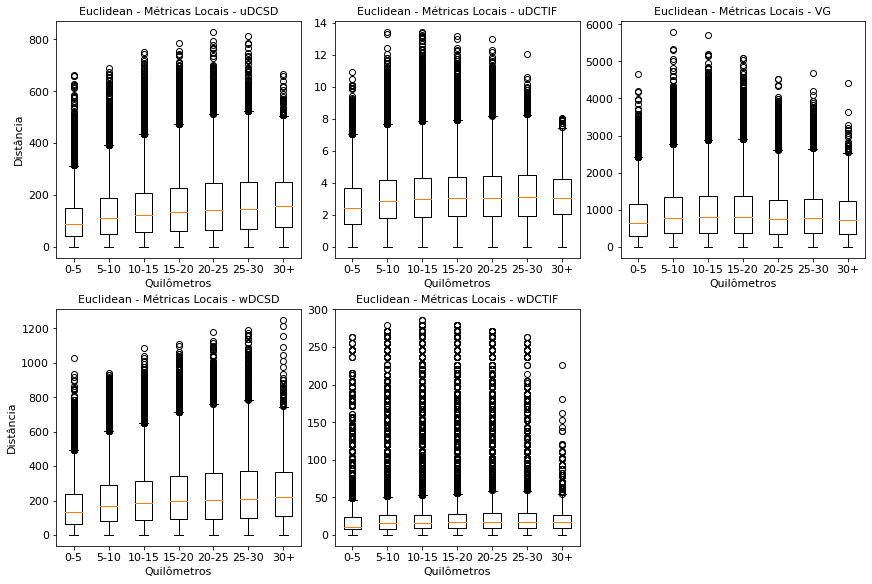

In [124]:
boxplot_seq(euclidean_dist_u_dcsd_local_metrics,euclidean_dist_u_dctif_local_metrics,euclidean_dist_u_vg_local_metrics,euclidean_dist_w_dcsd_local_metrics,euclidean_dist_w_dctif_local_metrics,'Euclidean','Métricas Locais',saving=0)

### Manhattan

In [ ]:
boxplot_seq(manhattan_dist_u_dcsd_local_metrics,manhattan_dist_u_dctif_local_metrics,manhattan_dist_u_vg_local_metrics,manhattan_dist_w_dcsd_local_metrics,manhattan_dist_w_dctif_local_metrics,'Manhattan','Métricas Locais',saving=1)

### Canberra

In [ ]:
boxplot_seq(canberra_dist_u_dcsd_local_metrics,canberra_dist_u_dctif_local_metrics,canberra_dist_u_vg_local_metrics,canberra_dist_w_dcsd_local_metrics,canberra_dist_w_dctif_local_metrics,'Canberra','Métricas Locais',saving=1)

### Cosine

In [ ]:
boxplot_seq(cosine_dist_u_dcsd_local_metrics,cosine_dist_u_dctif_local_metrics,cosine_dist_u_vg_local_metrics,cosine_dist_w_dcsd_local_metrics,cosine_dist_w_dctif_local_metrics,'Cosine','Métricas Locais',saving=1)

### Jensen-Shannon

In [ ]:
boxplot_seq(jensenshannon_dist_u_dcsd_local_metrics,jensenshannon_dist_u_dctif_local_metrics,jensenshannon_dist_u_vg_local_metrics,jensenshannon_dist_w_dcsd_local_metrics,jensenshannon_dist_w_dctif_local_metrics,'Jensen-Shannon','Métricas Locais',saving=1)

## Vetor de Métricas Globais

### Euclidean

In [ ]:
boxplot_seq(euclidean_dist_u_dcsd_global_metrics,euclidean_dist_u_dctif_global_metrics,euclidean_dist_u_vg_global_metrics,euclidean_dist_w_dcsd_global_metrics,euclidean_dist_w_dctif_global_metrics,'Euclidean','Métricas Globais',saving=1)

### Manhattan

In [ ]:
boxplot_seq(manhattan_dist_u_dcsd_global_metrics,manhattan_dist_u_dctif_global_metrics,manhattan_dist_u_vg_global_metrics,manhattan_dist_w_dcsd_global_metrics,manhattan_dist_w_dctif_global_metrics,'Manhattan','Métricas Globais',saving=1)

### Canberra

In [ ]:
boxplot_seq(canberra_dist_u_dcsd_global_metrics,canberra_dist_u_dctif_global_metrics,canberra_dist_u_vg_global_metrics,canberra_dist_w_dcsd_global_metrics,canberra_dist_w_dctif_global_metrics,'Canberra','Métricas Globais',saving=1)

### Cosine

In [ ]:
boxplot_seq(cosine_dist_u_dcsd_global_metrics,cosine_dist_u_dctif_global_metrics,cosine_dist_u_vg_global_metrics,cosine_dist_w_dcsd_global_metrics,cosine_dist_w_dctif_global_metrics,'Cosine','Métricas Globais',saving=1)

### Jensen-Shannon

In [ ]:
boxplot_seq(jensenshannon_dist_u_dcsd_global_metrics,jensenshannon_dist_u_dctif_global_metrics,jensenshannon_dist_u_vg_global_metrics,jensenshannon_dist_w_dcsd_global_metrics,jensenshannon_dist_w_dctif_global_metrics,'Jensen-Shannon','Métricas Globais',saving=1)

## Vetor de Métricas

### Euclidean

In [ ]:
boxplot_seq(euclidean_dist_u_dcsd_metrics,euclidean_dist_u_dctif_metrics,euclidean_dist_u_vg_metrics,euclidean_dist_w_dcsd_metrics,euclidean_dist_w_dctif_metrics,'Euclidean','Todas as métricas',saving=1)

### Manhattan

In [ ]:
boxplot_seq(manhattan_dist_u_dcsd_metrics,manhattan_dist_u_dctif_metrics,manhattan_dist_u_vg_metrics,manhattan_dist_w_dcsd_metrics,manhattan_dist_w_dctif_metrics,'Manhattan','Todas as métricas',saving=1)

### Canberra

In [ ]:
boxplot_seq(canberra_dist_u_dcsd_metrics,canberra_dist_u_dctif_metrics,canberra_dist_u_vg_metrics,canberra_dist_w_dcsd_metrics,canberra_dist_w_dctif_metrics,'Canberra','Todas as métricas',saving=1)

### Cosine

In [ ]:
boxplot_seq(cosine_dist_u_dcsd_metrics,cosine_dist_u_dctif_metrics,cosine_dist_u_vg_metrics,cosine_dist_w_dcsd_metrics,cosine_dist_w_dctif_metrics,'Cosine','Todas as métricas',saving=1)

### Jensen-Shannon

In [ ]:
boxplot_seq(jensenshannon_dist_u_dcsd_metrics,jensenshannon_dist_u_dctif_metrics,jensenshannon_dist_u_vg_metrics,jensenshannon_dist_w_dcsd_metrics,jensenshannon_dist_w_dctif_metrics,'Jensen-Shannon','Todas as métricas',saving=1)

## Vetor de Degree

### Euclidean

In [ ]:
boxplot_seq(euclidean_dist_u_dcsd_degrees,euclidean_dist_u_dctif_degrees,euclidean_dist_u_vg_degrees,euclidean_dist_w_dcsd_strength,euclidean_dist_w_dctif_strength,'Euclidean','DS',saving=1)

### Manhattan

In [ ]:
boxplot_seq(manhattan_dist_u_dcsd_degrees,manhattan_dist_u_dctif_degrees,manhattan_dist_u_vg_degrees,manhattan_dist_w_dcsd_strength,manhattan_dist_w_dctif_strength,'Manhattan','DS',saving=1)

### Canberra

In [ ]:
boxplot_seq(canberra_dist_u_dcsd_degrees,canberra_dist_u_dctif_degrees,canberra_dist_u_vg_degrees,canberra_dist_w_dcsd_strength,canberra_dist_w_dctif_strength,'Canberra','DS',saving=1)

### Cosine

In [ ]:
boxplot_seq(cosine_dist_u_dcsd_degrees,cosine_dist_u_dctif_degrees,cosine_dist_u_vg_degrees,cosine_dist_w_dcsd_strength,cosine_dist_w_dctif_strength,'Cosine','DS',saving=1)

### Jensen-Shannon

In [ ]:
boxplot_seq(jensenshannon_dist_u_dcsd_degrees,jensenshannon_dist_u_dctif_degrees,jensenshannon_dist_u_vg_degrees,jensenshannon_dist_w_dcsd_strength,jensenshannon_dist_w_dctif_strength,'Jensen-Shannon','DS',saving=1)

## Vetor de Closeness

### Euclidean

In [ ]:
boxplot_seq(euclidean_dist_u_dcsd_closeness,euclidean_dist_u_dctif_closeness,euclidean_dist_u_vg_closeness,euclidean_dist_w_dcsd_closeness,euclidean_dist_w_dctif_closeness,'Euclidean','Sequência de Closeness',saving=1)

### Manhattan

In [ ]:
boxplot_seq(manhattan_dist_u_dcsd_closeness,manhattan_dist_u_dctif_closeness,manhattan_dist_u_vg_closeness,manhattan_dist_w_dcsd_closeness,manhattan_dist_w_dctif_closeness,'Manhattan','Sequência de Closeness',saving=1)

### Canberra

In [ ]:
boxplot_seq(canberra_dist_u_dcsd_closeness,canberra_dist_u_dctif_closeness,canberra_dist_u_vg_closeness,canberra_dist_w_dcsd_closeness,canberra_dist_w_dctif_closeness,'Canberra','Sequência de Closeness',saving=1)

### Cosine

In [ ]:
boxplot_seq(cosine_dist_u_dcsd_closeness,cosine_dist_u_dctif_closeness,cosine_dist_u_vg_closeness,cosine_dist_w_dcsd_closeness,cosine_dist_w_dctif_closeness,'Cosine','Sequência de Closeness',saving=1)

### Jensen-Shannon

In [ ]:
boxplot_seq(jensenshannon_dist_u_dcsd_closeness,jensenshannon_dist_u_dctif_closeness,jensenshannon_dist_u_vg_closeness,jensenshannon_dist_w_dcsd_closeness,jensenshannon_dist_w_dctif_closeness,'Jensen-Shannon','Sequência de Closeness',saving=1)

## Vetor de Betweenness

### Euclidean

In [ ]:
boxplot_seq(euclidean_dist_u_dcsd_betweenness,euclidean_dist_u_dctif_betweenness,euclidean_dist_u_vg_betweenness,euclidean_dist_w_dcsd_betweenness,euclidean_dist_w_dctif_betweenness,'Euclidean','Sequência de Betweenness',saving=1)

### Manhattan

In [ ]:
boxplot_seq(manhattan_dist_u_dcsd_betweenness,manhattan_dist_u_dctif_betweenness,manhattan_dist_u_vg_betweenness,manhattan_dist_w_dcsd_betweenness,manhattan_dist_w_dctif_betweenness,'Manhattan','Sequência de Betweenness',saving=1)

### Canberra

In [ ]:
boxplot_seq(canberra_dist_u_dcsd_betweenness,canberra_dist_u_dctif_betweenness,canberra_dist_u_vg_betweenness,canberra_dist_w_dcsd_betweenness,canberra_dist_w_dctif_betweenness,'Canberra','Sequência de Betweenness',saving=1)

### Cosine

In [ ]:
boxplot_seq(cosine_dist_u_dcsd_betweenness,cosine_dist_u_dctif_betweenness,cosine_dist_u_vg_betweenness,cosine_dist_w_dcsd_betweenness,cosine_dist_w_dctif_betweenness,'Cosine','Sequência de Betweenness',saving=1)

### Jensen-Shannon

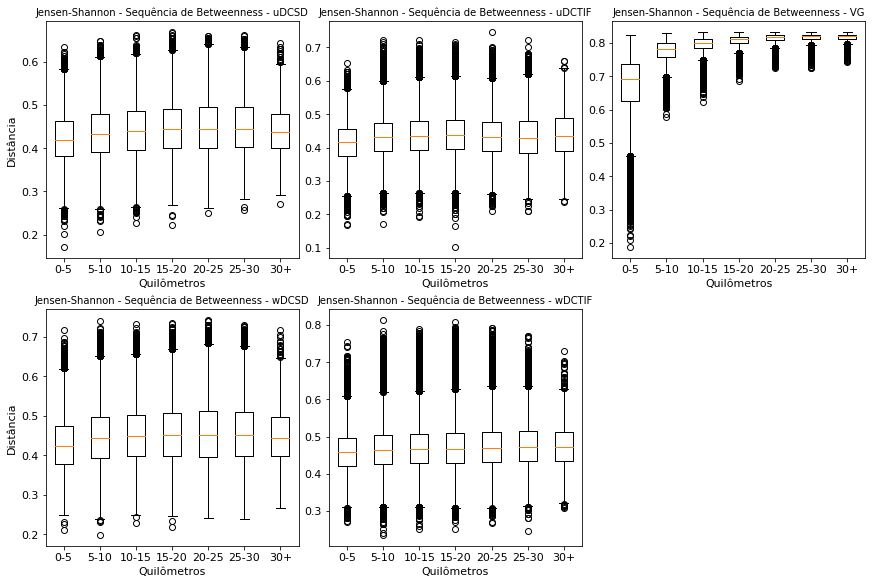

In [127]:
boxplot_seq(jensenshannon_dist_u_dcsd_betweenness,jensenshannon_dist_u_dctif_betweenness,jensenshannon_dist_u_vg_betweenness,jensenshannon_dist_w_dcsd_betweenness,jensenshannon_dist_w_dctif_betweenness,'Jensen-Shannon','Sequência de Betweenness',saving=0)

# Reconstrução do grafo geográfico

In [5]:
def g_graph(data):
    """
    Parameters:
    -----------
        data - Dicionário contendo os pares de séries temporais e seus respectivos pesos. Cada par presente no 
        dicionário representa uma conexão entre dois nós da rede.
    Returns:
    --------
        plt - Contém o plot do grafo
        gr - Variável contendo o objeto grafo do tipo igraph 
    """
    gr = igraph.Graph();
    gr.add_vertices(587); # Valor estático. O número de nós na rede geográfica é constante.
    gr.add_edges((list(data.keys())));
    gr.vs['x'] = [position[i][1] for i in range(587)];
    gr.vs['y'] = [position[j][0] for j in range(587)];
    gr.es['weight'] = [i[1] for i in list(data.values())];
    lyt = [];
    for i in range(587):
        lyt.append( (gr.vs[i]['x'],gr.vs[i]['y']) );
    visual_style = {};
    visual_style['layout'] = lyt;
    visual_style['bbox'] = (500,500);
    visual_style['margin'] = 20;
    visual_style['vertex_size'] = 5;
    visual_style['edge_width'] = 1.5;
    plt = igraph.plot(gr,**visual_style);
    #igraph.plot(gr,'basin-region-js-0dot358.png',**visual_style);
    return(plt,gr); #plot object and the graph itself

In [6]:
# Dictionary containing the topological distance between two points
        # unweighted shortest path - BFS algorithm
        # weighted shortest path - Djikstra algorithm
def shortest_paths(g, weight):
    """
    Parameters:
    -----------
        Graph object (igraph)
    Returns:
    --------
        The shortest path between all connected nodes
    """
    s_paths = {};
    if not (weight):
        ctrl = 1;
        for i in range(g.vcount()):
            for j in range(ctrl,g.vcount()):
                path = g.shortest_paths(source=g.vs[i],target=g.vs[j])
                if (path[0][0] != float('inf')):
                    s_paths[i,j] = path[0][0];
            ctrl+=1
    else:
        ctrl = 1;
        for i in range(g.vcount()):
            for j in range(ctrl,g.vcount()):
                path = g.shortest_paths(source=g.vs[i],target=g.vs[j],weights=g.es['weight']) 
                if (path[0][0] != float('inf')):
                    s_paths[i,j] = path[0][0];
            ctrl+=1
        
    return(s_paths);

In [7]:
def plot_geo_top(data):
    """
    Parameters:
    -----------
        data - Dicionário contendo os pares de séries temporais e seus respectivos pesos. Cada par presente no 
        dicionário representa uma conexão entre dois nós da rede.
        
        Retorna um gráfico contendo a distância geográfica no eixo das abscissas e distância topológica no eixo das
        ordenadas, bem como as informações do modelo de regressão linear usado para mostrar a relação entre os eixos.
    """
    geo = np.array([i[1] for i in list(data.values())]);
    top = np.array([i[0] for i in list(data.values())]);
    geo = geo.reshape(-1,1);
    top = top.reshape(-1,1);
    # Linear Regression
    reg = LinearRegression();
    reg.fit(geo,top);
    score = round(reg.score(geo,top),4);
    a = round(reg.coef_[0][0],4);
    b = reg.intercept_;
    top_new = (a*geo) + b;
    # Plot
    plt.figure(figsize=(15,10));
    plt.scatter(geo,top,s=20,alpha=0.2);
    plt.plot(geo,top_new,color='red');
    plt.grid(True);
    plt.xlabel('Geographical Distance [km]',fontsize='xx-large');
    plt.ylabel('Topological Distance [Number of edges]',fontsize='xx-large');
    plt.text((max(geo)*0.5)[0], (min(top))[0], 'R² = '+str(score), horizontalalignment='center',verticalalignment='center',fontsize='xx-large');
    plt.text((max(geo)*0.75)[0], (min(top))[0], 'Slope = '+str(a), horizontalalignment='center',verticalalignment='center',fontsize='xx-large');

---
#### Threshold definition based in the highest diameter

In [8]:
# Remover arestas com peso abaixo de um dado threshold (valor real)
# entrada: g, flow_threshold
# retorno: g
def remove_edges(g, flow_threshold):
    del_edges = []
    for e in g.es():
        if e['weight'] < flow_threshold:
            del_edges.append(e)
    g.delete_edges(del_edges)
    return g

#ng = remove_edges(g, 6.1)
#print(ng)

# Função que varia o threshold e chama a função acima 
# remover as arestas abaixo do threshold e em seguida verifica o diâmetro
# Entrada: g
# Retorno: threshold (valor real) associado ao maior diâmetro da rede
def max_diameter_threshold(g):
    max_threshold = max(g.es['weight'])
    max_diameter = 0
    for threshold in np.arange(0.1, max_threshold, 0.01):
        print(threshold)
        ng = g.copy()
        ng = remove_edges(ng, threshold)
        #print(ng)
        diameter = ng.diameter(directed=False)
        print(diameter)
        if diameter > max_diameter:
            max_diameter = diameter
            threshold_max_diameter = threshold
    return threshold_max_diameter

---
## Estabelecendo links usando Mutual Information

In [14]:
def mutual_information(ts,thrshld):
    """
    Parameters:
    -----------
        ts - Conjunto de séries temporais lidas inicialmente. Cada série é comparada com todas as outras usando 
        mutual information. 
        thrshld - É o valor de limiar que limita quais séries serão conectadas. Para o caso do mutual information, 
        as séries serão conectadas se o valor obtido na comparação for maior que o threshold.
    Returns:
    --------
        mi_dict - Retorna um dicionário contendo os pares de séries cujo valor de mutual information foi superior
        ao limiar determinado. As chaves correspondem às séries e os valores são a distância geográfica entre essas
        séries e o valor de peso que será usado para construir o grafo geográfico.
    """    
    mi_dict = {};
    ctrl = 1;
    for i in range(len(ts)):
        for j in range(ctrl,len(ts)):
            mi = sk.normalized_mutual_info_score(ts[i], ts[j], average_method='arithmetic');
            if (mi >= thrshld):
                mi_dict[i,j] = [geo_dist[i,j],(1/mi)];
        ctrl += 1;
    return(mi_dict);

In [67]:
# Execution time: 300s
i = time.time();
mutual_inf_all_edges = mutual_information(meteorological_time_series,thrshld=0);
e = time.time();
print(e-i);

308.79888939857483


In [68]:
mutual_inf_thrshld = {}
for i in mutual_inf_all_edges:
    if (mutual_inf_all_edges[i][1]) > 0.5833:
        mutual_inf_thrshld[i] = mutual_inf_all_edges[i]

In [69]:
len(mutual_inf_all_edges)

171991

In [61]:
g_graph_mi_thrshld_1270 = g_graph(mutual_inf_all_edges); # [plot, graph]

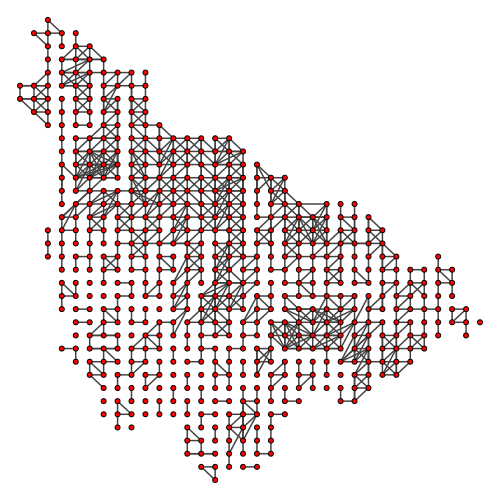

In [62]:
# Graph plot - Mutual Information
g_graph_mi_thrshld_1270[0]

In [63]:
# Execution time: 29s
# Shortest paths - Mutual Information 
i = time.time();
s_paths_mi_unweighted = shortest_paths(g_graph_mi_thrshld_1270[1],weight=False);
s_paths_mi_weighted = shortest_paths(g_graph_mi_thrshld_1270[1],weight=True);
e = time.time();
print(e - i);

30.61405110359192


In [64]:
# Shortest paths and Geographical distance - Mutual Information
topological_geographical_dist_mi_unweighted = {}; # First: Topological distance; Second: Geographical distance
topological_geographical_dist_mi_weighted = {}; # First: Topological distance; Second: Geographical distance
for i in s_paths_mi_unweighted:
    topological_geographical_dist_mi_unweighted[i] = [s_paths_mi_unweighted[i],geo_dist[i]];
    topological_geographical_dist_mi_weighted[i] = [s_paths_mi_weighted[i],geo_dist[i]];

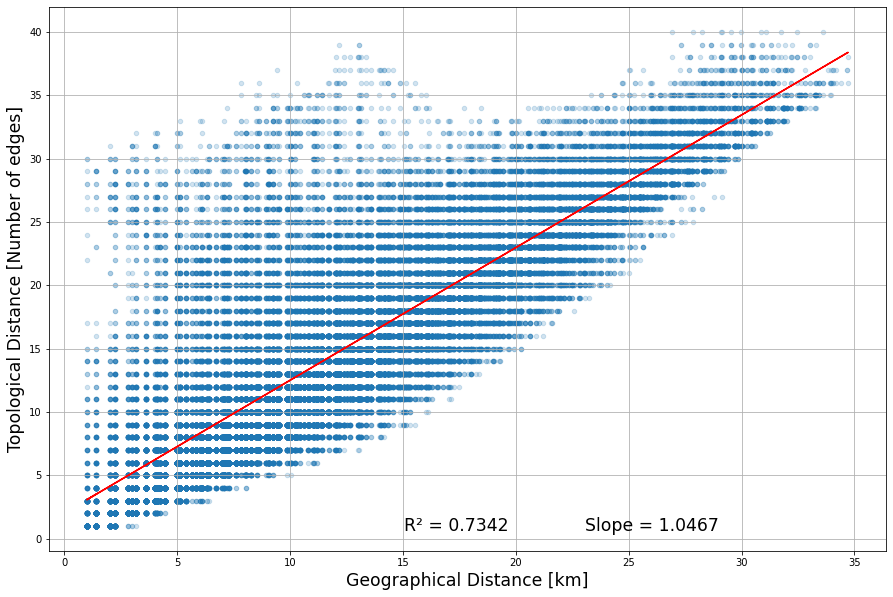

In [65]:
# Geographical Distance x Topological Distance (Unweighted)
plot_geo_top(topological_geographical_dist_mi_unweighted)

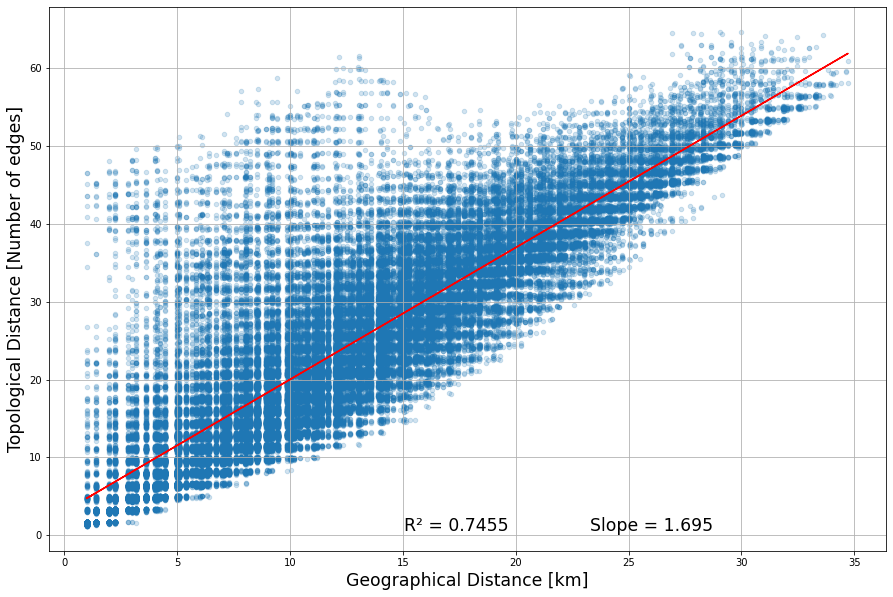

In [66]:
# Geographical Distance x Topological Distance (Weighted)
plot_geo_top(topological_geographical_dist_mi_weighted)

---
## Estabelecendo links usando Pearson Correlation

In [13]:
def pearson_correlation(ts,thrshld):
    """
    Parameters:
    -----------
        ts - Conjunto de séries temporais lidas inicialmente. Cada série é comparada com todas as outras usando 
        mutual information. 
        thrshld - É o valor de limiar que limita quais séries serão conectadas. Para o caso da correlação de 
        Pearson, as séries serão conectadas se o valor obtido na comparação for maior que o threshold.
    Returns:
    --------
        mi_dict - Retorna um dicionário contendo os pares de séries cujo coeficiente de correlação de Pearson
        foi superior ao limiar determinado. As chaves correspondem às séries e os valores são a distância 
        geográfica entre essas séries e o valor de peso que será usado para construir o grafo geográfico.
    """
    ctrl = 1; # Used to avoid comparisons between equal and simetric series
    pc_dict = {};
    for i in range(len(ts)):
        for j in range(ctrl,len(ts)):
            corr = scipy.stats.pearsonr(ts[i],ts[j])[0]
            if (corr >= thrshld):
                pc_dict[i,j] = [geo_dist[i,j], (1/corr)];
        ctrl += 1;
    return(pc_dict);

In [14]:
# Execution time: 14s
i = time.time();
pearson = pearson_correlation(meteorological_time_series,thrshld=0.86);
e = time.time();
print(e-i);

14.697954416275024


In [15]:
p = [i[0] for i in list(pearson.values())]
# Comprimento, em km, da maior conexão usando Pearson Correlation
print("Comprimento, em km, da maior conexão usando Pearson Correlation",round(max(p),4))
print("Número de conexões: ",len(p))

Comprimento, em km, da maior conexão usando Pearson Correlation 3.1623
Número de conexões:  1270


In [16]:
g_graph_pc = g_graph(pearson);

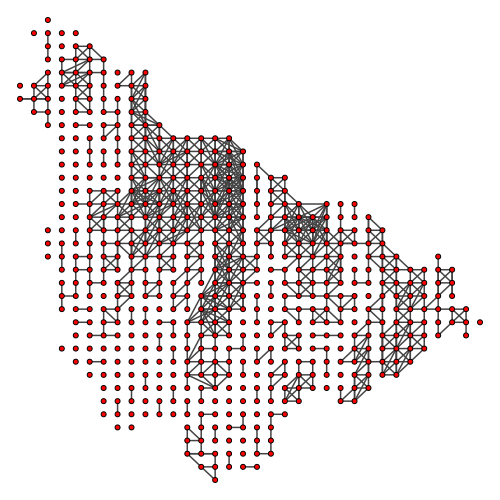

In [17]:
# Graph plot - Pearson Correlation
g_graph_pc[0]

In [18]:
# Execution time: 27s
# Shortest paths - Pearson Correlation 
i = time.time();
s_paths_pc_unweighted = shortest_paths(g_graph_pc[1],weight=False);
s_paths_pc_weighted = shortest_paths(g_graph_pc[1],weight=True);
e = time.time();
print(e-i);

28.42976999282837


In [19]:
# Shortest paths and Geographical distance - Pearson Correlation
topological_geographical_dist_pc_unweighted = {}; # First: Topological distance; Second: Geographical distance
topological_geographical_dist_pc_weighted = {}; # First: Topological distance; Second: Geographical distance
for i in s_paths_pc_unweighted:
    topological_geographical_dist_pc_unweighted[i] = [s_paths_pc_unweighted[i],geo_dist[i]];
    topological_geographical_dist_pc_weighted[i] = [s_paths_pc_weighted[i],geo_dist[i]];

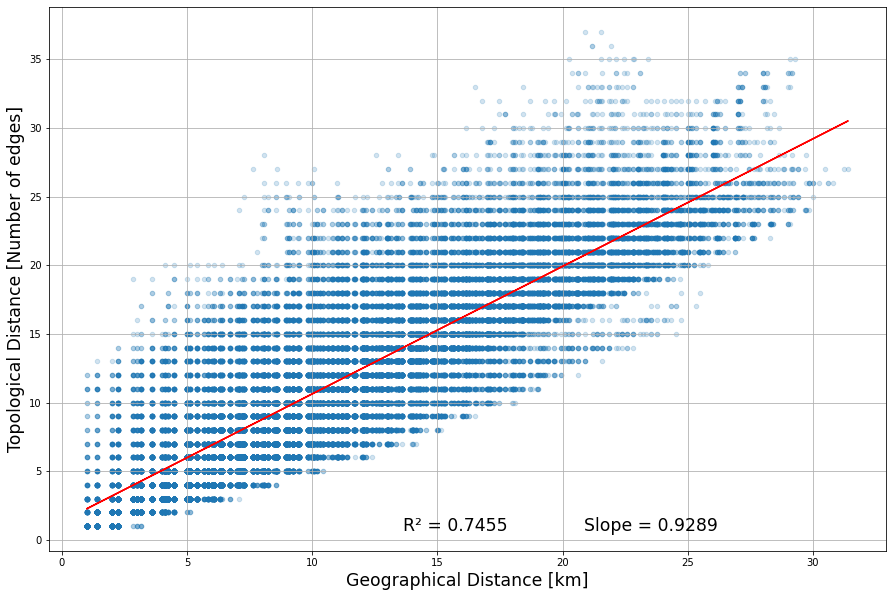

In [20]:
# Geographical Distance x Topological Distance (Unweighted)
plot_geo_top(topological_geographical_dist_pc_unweighted)

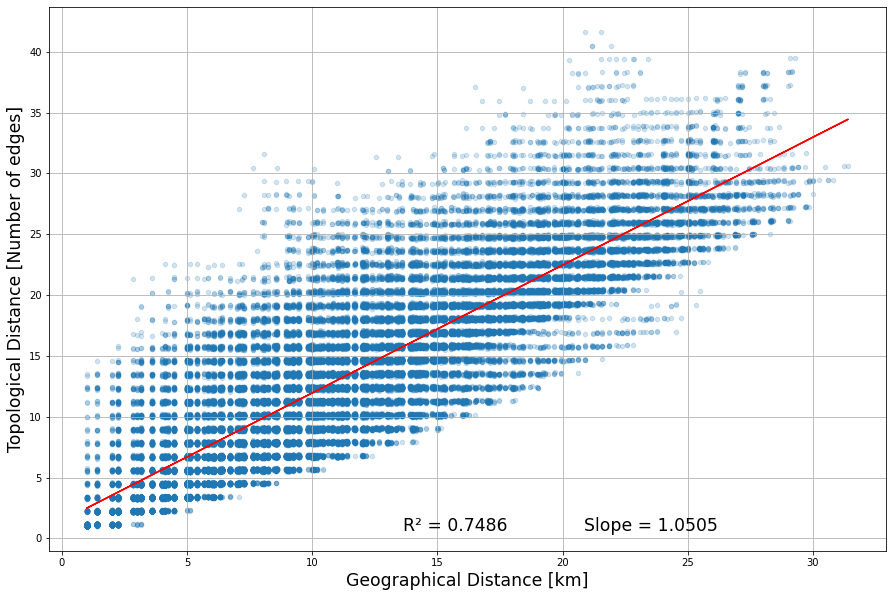

In [21]:
# Geographical Distance x Topological Distance (Weighted)
# A própria correlação (para este caso foi usado o 1/correlação) funciona como peso para a rede
plot_geo_top(topological_geographical_dist_pc_weighted)

## Estabelecendo links usando:
    
   - Jensen-Shanon Distance entre a distribuição de graus da rede
   - Jensen-Shannon Distance entre a distribuição de betweenness da rede
   - Cosine Similarity entre a distribuição de graus da rede

In [106]:
# jensen-shannon distance - degree
js_dist_degree_thrshld = {};
thrshld = 1 #0.3072;
for i in jensenshannon_dist_u_vg_degrees:
    if jensenshannon_dist_u_vg_degrees[i] <= thrshld:
        js_dist_degree_thrshld[i] = [geo_dist[i],jensenshannon_dist_u_vg_degrees[i]];

In [63]:
# jensen-shannon distance - betweenness
js_dist_btwnss_thrshld = {};
btw_thrshld = 0.52711;
for i in jensenshannon_dist_u_vg_betweenness:
    if jensenshannon_dist_u_vg_betweenness[i] <= btw_thrshld:
        js_dist_btwnss_thrshld[i] = [geo_dist[i],jensenshannon_dist_u_vg_betweenness[i]];

In [64]:
# Cosine distance - degree
cosine_dist_degree_thrshld = {};
cosine_degree_thrshld = 0.37767;
for i in cosine_dist_u_vg_degrees:
    if cosine_dist_u_vg_degrees[i] <= cosine_degree_thrshld:
        cosine_dist_degree_thrshld[i] = [geo_dist[i],cosine_dist_u_vg_degrees[i]];

In [61]:
js = [i[0] for i in list(js_dist_degree_thrshld.values())]
print("Comprimento, em km, da maior conexão usando Jensen-Shannon Distance (Degree):",round(max(js),4));
print("Número de conexões:",len(js));

Comprimento, em km, da maior conexão usando Jensen-Shannon Distance (Degree): 38.833
Número de conexões: 171854


In [22]:
js_btw = [i[0] for i in list(js_dist_btwnss_thrshld.values())]
print("Comprimento, em km, da maior conexão usando Jensen-Shannon Distance (Betweenness):",round(max(js),4));
print("Número de conexões:",len(js_btw));

Comprimento, em km, da maior conexão usando Jensen-Shannon Distance (Betweenness): 3.1623
Número de conexões: 1270


In [23]:
cosine_degree = [i[0] for i in list(cosine_dist_degree_thrshld.values())]
print("Comprimento, em km, da maior conexão usando Cosine Similarity (Degree):",round(max(js),4));
print("Número de conexões:",len(cosine_degree));

Comprimento, em km, da maior conexão usando Cosine Similarity (Degree): 3.1623
Número de conexões: 1270


In [65]:
g_graph_js_degree = g_graph(js_dist_degree_thrshld);
g_graph_cosine_degree = g_graph(cosine_dist_degree_thrshld);
g_graph_js_btwnss = g_graph(js_dist_btwnss_thrshld);

In [ ]:
#  Graph plot - Jensen-Shannon Distance (Degree)
g_graph_js_degree[0]

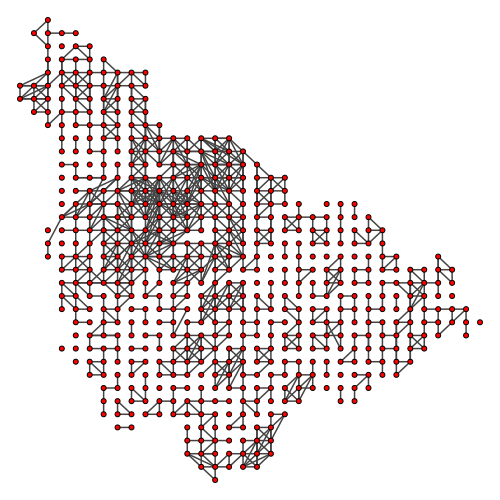

In [31]:
#  Graph plot - Cosine Distance (Degree)
g_graph_cosine_degree[0]

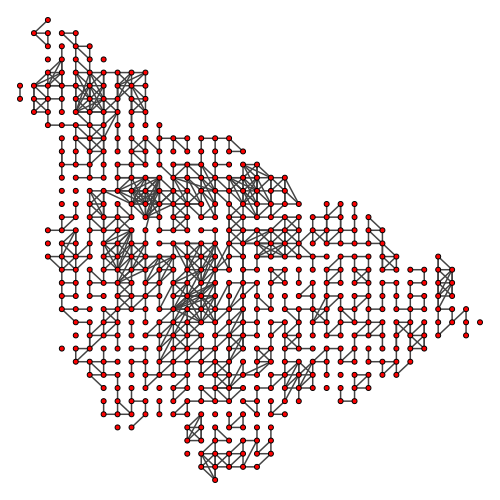

In [32]:
#  Graph plot - Jensen-Shannon Distance (Betweenness)
g_graph_js_btwnss[0]

In [37]:
# Execution time: 57s
# Shortest paths - Jensen-Shannon Distance (Degree)
# Shortest paths - Cosine Similarity (Degree)
i = time.time();
s_paths_js_unweighted = shortest_paths(g_graph_js_degree[1],weight=False);
s_paths_js_weighted = shortest_paths(g_graph_js_degree[1],weight=True);
s_paths_cosine_unweighted = shortest_paths(g_graph_cosine_degree[1],weight=False);
s_paths_cosine_weighted = shortest_paths(g_graph_cosine_degree[1],weight=True);
e = time.time();
print(e-i);

57.73865723609924


In [38]:
# Shortest paths and Geographical distances - Jensen-Shannon Distance and Cosine Similatiry
topological_geographical_dist_js_unweighted = {}; # First: Topological distance; Second: Geographical distance
topological_geographical_dist_js_weighted = {}; # First: Topological distance; Second: Geographical distance
topological_geographical_dist_cosine_unweighted = {}; # First: Topological distance; Second: Geographical distance
topological_geographical_dist_cosine_weighted = {}; # First: Topological distance; Second: Geographical distance
for i in s_paths_js_unweighted:
    topological_geographical_dist_js_unweighted[i] = [s_paths_js_unweighted[i],geo_dist[i]];
    topological_geographical_dist_js_weighted[i] = [s_paths_js_weighted[i],geo_dist[i]];
for i in s_paths_cosine_unweighted:
    topological_geographical_dist_cosine_unweighted[i] = [s_paths_cosine_unweighted[i],geo_dist[i]];
    topological_geographical_dist_cosine_weighted[i] = [s_paths_cosine_weighted[i],geo_dist[i]];    

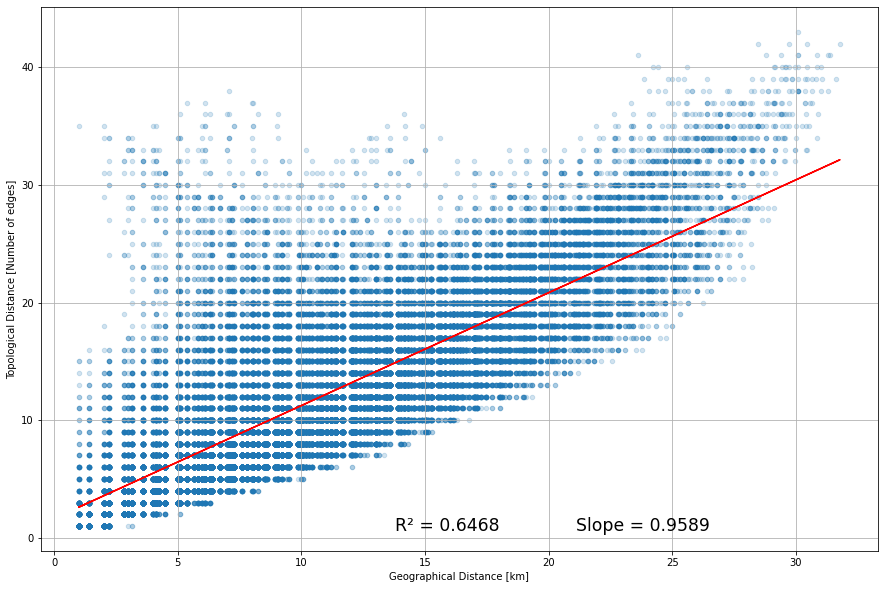

In [39]:
# Geographical Distance x Topological Distance (Jensen-Shannon Unweighted)
plot_geo_top(topological_geographical_dist_js_unweighted)

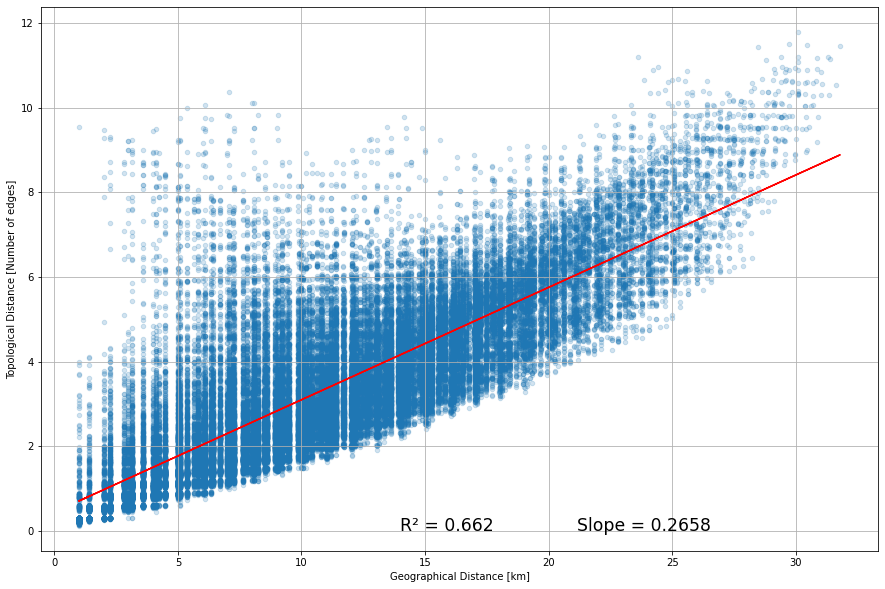

In [40]:
# Geographical Distance x Topological Distance (Jensen-Shannon Weighted)
plot_geo_top(topological_geographical_dist_js_weighted)

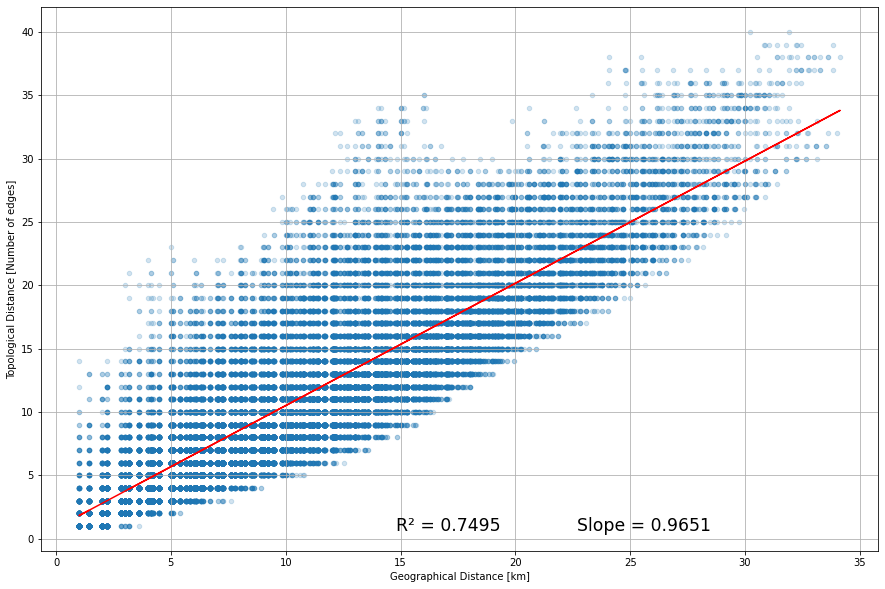

In [41]:
# Geographical Distance x Topological Distance (Cosine Unweighted)
plot_geo_top(topological_geographical_dist_cosine_unweighted)

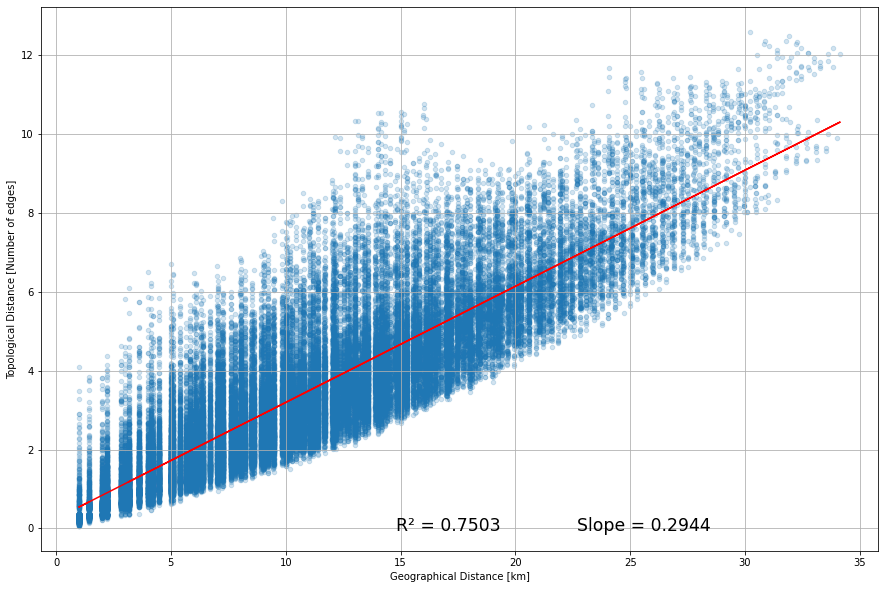

In [42]:
# Geographical Distance x Topological Distance (Cosine Weighted)
plot_geo_top(topological_geographical_dist_cosine_weighted)

# Global-threshold and Backbone

In [2]:
gt_graph = igraph.Graph.Read_GraphML('gt-bb-weather-radar-watershed/GT.GraphML')
bb_graph = igraph.Graph.Read_GraphML('gt-bb-weather-radar-watershed/BB.GraphML')
original_graph = igraph.Graph.Read_GraphML('gt-bb-weather-radar-watershed/Original.GraphML')

#### Teste de hipótese para as redes Jensen-Shannon e Cosine

#### Avg Shortest Paths

In [20]:
def avg_shortest_path(graph):
    avg_shortest_paths = {}
    shrtst_paths_inf = graph.shortest_paths()
    sp = [];
    for nodes in range(len(shrtst_paths_inf)):
        v = [];
        for paths in range(len(shrtst_paths_inf[nodes])):
            if ((shrtst_paths_inf[nodes][paths] != float('inf')) and (shrtst_paths_inf[nodes][paths] != 0) and (nodes != paths)):
                v.append(shrtst_paths_inf[nodes][paths]);
        if (len(v) == 0):
            avg = 0;
        else:
            avg = sum(v)/len(v);
        sp.append(avg);

    for i in range(587):
        avg_shortest_paths[i] = sp[i]
    
    return(avg_shortest_paths)

In [177]:
avg_sp_js_per_node = avg_shortest_path(g_graph_js_degree[1])
avg_sp_cosine_per_node = avg_shortest_path(g_graph_cosine_degree[1])
avg_sp_mi_per_node = avg_shortest_path(g_graph_mi_thrshld_diameter[1])

In [28]:
# Average shortest path - Pearson Correlation
count = 0;
s = 0
for i in range(len(gt_graph.vs['shortestPathMean'])):
    if gt_graph.vs['shortestPathMean'][i] != 0:
        count += 1
        s += gt_graph.vs['shortestPathMean'][i]
avg_sp_pc = s/count;

In [178]:
# Average shortest path - Mutual Information
count = 0;
s = 0
for i in range(len(avg_sp_mi_per_node)):
    if list(avg_sp_mi_per_node.values())[i] != 0:
        count += 1
        s += list(avg_sp_mi_per_node.values())[i]
avg_sp_mi_all = s/count;

In [30]:
# Average shortest path - Jensen-Shannon (Degree sequence)
count = 0;
s = 0
for i in range(len(avg_sp_js_per_node)):
    if list(avg_sp_js_per_node.values())[i] != 0:
        count += 1
        s += list(avg_sp_js_per_node.values())[i]
avg_sp_js_all = s/count;

In [31]:
# Average shortest path - Cosine (Degree sequence)
count = 0;
s = 0
for i in range(len(avg_sp_cosine_per_node)):
    if list(avg_sp_cosine_per_node.values())[i] != 0:
        count += 1
        s += list(avg_sp_cosine_per_node.values())[i]
avg_sp_cosine_all = s/count;

----
#### Shared Edges

In [39]:
# Shared edges between Jensen-Shannon based network and Pearson based networks
eq_js_gt = 0; 
eq_js_bb = 0;
eq_js_gt_edges = []; 
eq_js_bb_edges = [];
for i in list(js_dist_degree_thrshld.keys()):
    for j in gt_graph.get_edgelist():
        if i == j:
            eq_js_gt += 1
            eq_js_gt_edges.append(j)
    for k in bb_graph.get_edgelist():
        if i == k:
            eq_js_bb += 1
            eq_js_bb_edges.append(k)

In [40]:
# Shared edges between Cosine based network and Pearson based networks
eq_cosine_gt = 0; 
eq_cosine_bb = 0;
eq_cosine_gt_edges =[]; 
eq_cosine_bb_edges = [];
for i in list(cosine_dist_degree_thrshld.keys()):
    for j in gt_graph.get_edgelist():
        if i == j:
            eq_cosine_gt += 1
            eq_cosine_gt_edges.append(j)
    for k in bb_graph.get_edgelist():
        if i == k:
            eq_cosine_bb += 1
            eq_cosine_bb_edges.append(k)

---
#### Metrics

In [179]:
# Components

def comp(graph):
    n_comp = len(graph.components())
    n_singletons = len([i for i in graph.components().sizes() if i == 1])
    biggest_comp = max(graph.components().sizes())
    avg_comp = sum(graph.components().sizes())/n_comp
    return([n_comp,n_singletons,biggest_comp,avg_comp])

In [182]:
# Metrics - Mutual Information

print("Weight: {:.4f} - {:.4f}".format((1/max(np.array(list(mutual_inf_thrshld_diameter.values()))[:,1])),(1/min(np.array(list(mutual_inf_thrshld_diameter.values()))[:,1]))))
print("Average shortest path: {:.4f}".format(avg_sp_mi_all))
print("Diameter: {}".format(g_graph_mi_thrshld_diameter[1].diameter()))
print("Clustering coefficient: {:.4f}".format(g_graph_mi_thrshld_diameter[1].transitivity_undirected()))
print("Parâmetro de heterogeneidade: {:.4f}".format(heterogeinity(g_graph_mi_thrshld_diameter[1].degree())))
print("Número de componentes: {}".format(comp(g_graph_mi_thrshld_diameter[1])[0]))
print("Número de singletons: {}".format(comp(g_graph_mi_thrshld_diameter[1])[1]))
print("Tamanho do maior componente: {}".format(comp(g_graph_mi_thrshld_diameter[1])[2]))
print("Média dos tamanhos dos componentes: {:.2f}".format(comp(g_graph_mi_thrshld_diameter[1])[3]))

Weight: 0.6000 - 0.8495
Average shortest path: 10.3812
Diameter: 49
Clustering coefficient: 0.4744
Parâmetro de heterogeneidade: 1.4228
Número de componentes: 82
Número de singletons: 33
Tamanho do maior componente: 305
Média dos tamanhos dos componentes: 7.16


In [60]:
# Metrics - Pearson Correlation - GT

print("Weight: {:.4f} - {:.4f}".format((1/max(np.array(list(pearson.values()))[:,1])),(1/min(np.array(list(pearson.values()))[:,1]))))
print("Average shortest path: {:.4f}".format(avg_sp_pc))
print("Diameter: {}".format(g_graph_pc[1].diameter()))
print("Clustering coefficient: {:.4f}".format(g_graph_pc[1].transitivity_undirected()))
print("Parâmetro de heterogeneidade: {:.4f}".format(heterogeinity(g_graph_pc[1].degree())))
print("Número de componentes: {}".format(comp(g_graph_pc[1])[0]))
print("Número de singletons: {}".format(comp(g_graph_pc[1])[1]))
print("Tamanho do maior componente: {}".format(comp(g_graph_pc[1])[2]))
print("Média dos tamanhos dos componentes: {:.2f}".format(comp(g_graph_pc[1])[3]))

Weight: 0.8600 - 0.9828
Average shortest path: 8.9352
Diameter: 37
Clustering coefficient: 0.5363
Parâmetro de heterogeneidade: 1.7753
Número de componentes: 125
Número de singletons: 85
Tamanho do maior componente: 349
Média dos tamanhos dos componentes: 4.70


In [104]:
# Metrics - Pearson Correlation - BB

print("Weight: {:.4f} - {:.4f}".format(min(bb_graph.es['weight']),max(bb_graph.es['weight'])))
print("Average shortest path: {:.4f}".format(sum([i for i in bb_graph.vs['shortestPathMean'] if i != 0])/len([i for i in bb_graph.vs['shortestPathMean'] if i != 0])))
print("Diameter: {}".format(bb_graph.diameter()))
print("Clustering coefficient: {:.4f}".format(sum([i for i in bb_graph.vs['clusterCoeficient'] if (not(i != i))])/len([i for i in bb_graph.vs['clusterCoeficient'] if (not(i != i))])))
print("Parâmetro de heterogeneidade: {:.4f}".format(heterogeinity(bb_graph.degree())))
print("Número de componentes: {}".format(comp(bb_graph)[0]))
print("Número de singletons: {}".format(comp(bb_graph)[1]))
print("Tamanho do maior componente: {}".format(comp(bb_graph)[2]))
print("Média dos tamanhos dos componentes: {:.2f}".format(comp(bb_graph)[3]))

Weight: 0.2796 - 0.9517
Average shortest path: 4.4229
Diameter: 19
Clustering coefficient: 0.2258
Parâmetro de heterogeneidade: 3.2625
Número de componentes: 237
Número de singletons: 218
Tamanho do maior componente: 161
Média dos tamanhos dos componentes: 2.48


In [67]:
# Metrics - Jensen-Shannon Distance between degree distribution
print("Weight: {:.4f} - {:.4f}".format(min(np.array(list(js_dist_degree_thrshld.values()))[:,1]),max(np.array(list(js_dist_degree_thrshld.values()))[:,1])))
print("Average shortest path: {:.4f}".format(avg_sp_js_all))
print("Diameter: {}".format(g_graph_js_degree[1].diameter()))
print("Clustering coefficient: {:.4f}".format(g_graph_js_degree[1].transitivity_undirected()))
print("Parâmetro de heterogeneidade: {:.4f}".format(heterogeinity(g_graph_js_degree[1].degree())))
print("Shared edges \n\tJS and GT (Pearson): {} ({:.4f}%)\n\tJS and BB (Pearson): {} ({:.4f}%)".format(eq_js_gt,100*eq_js_gt/1270,eq_js_bb,100*eq_js_bb/1270))
print("Número de componentes: {}".format(comp(g_graph_js_degree[1])[0]))
print("Número de singletons: {}".format(comp(g_graph_js_degree[1])[1]))
print("Tamanho do maior componente: {}".format(comp(g_graph_js_degree[1])[2]))
print("Média dos tamanhos dos componentes: {:.2f}".format(comp(g_graph_js_degree[1])[3]))

Weight: 0.1084 - 0.3071
Average shortest path: 9.0801
Diameter: 43
Clustering coefficient: 0.4818
Parâmetro de heterogeneidade: 1.4401
Shared edges 
	JS and GT (Pearson): 928 (73.0709%)
	JS and BB (Pearson): 99 (7.7953%)
Número de componentes: 36
Número de singletons: 13
Tamanho do maior componente: 369
Média dos tamanhos dos componentes: 16.31


In [68]:
# Metrics - Cosine Similarity between degree distribution
print("Weight: {:.4f} - {:.4f}".format(min(np.array(list(cosine_dist_degree_thrshld.values()))[:,1]),max(np.array(list(cosine_dist_degree_thrshld.values()))[:,1])))
print("Average shortest path: {:.4f}".format(avg_sp_cosine_all))
print("Diameter: {}".format(g_graph_cosine_degree[1].diameter()))
print("Clustering coefficient: {:.4f}".format(g_graph_cosine_degree[1].transitivity_undirected()))
print("Parâmetro de heterogeneidade: {:.4f}".format(heterogeinity(g_graph_cosine_degree[1].degree())))
print("Shared edges \n\tCosine and GT (Pearson): {} ({:.4f}%)\n\tCosine and BB (Pearson): {} ({:.4f}%)".format(eq_cosine_gt,100*eq_cosine_gt/1270,eq_cosine_bb,100*eq_cosine_bb/1270))
print("Número de componentes: {}".format(comp(g_graph_cosine_degree[1])[0]))
print("Número de singletons: {}".format(comp(g_graph_cosine_degree[1])[1]))
print("Tamanho do maior componente: {}".format(comp(g_graph_cosine_degree[1])[2]))
print("Média dos tamanhos dos componentes: {:.2f}".format(comp(g_graph_cosine_degree[1])[3]))

Weight: 0.0592 - 0.3777
Average shortest path: 8.5693
Diameter: 40
Clustering coefficient: 0.4939
Parâmetro de heterogeneidade: 1.5265
Shared edges 
	Cosine and GT (Pearson): 866 (68.1890%)
	Cosine and BB (Pearson): 111 (8.7402%)
Número de componentes: 52
Número de singletons: 24
Tamanho do maior componente: 352
Média dos tamanhos dos componentes: 11.29


___
### Comparações

> **Jensen-Shannon - Degree Sequence**: Séries temporais são convertidas em através do VG e as sequências de grau são comparadas, par a par, usando a distância de Jensen-Shannon.

> **Cosine - Degree Sequence**: Séries temporais são convertidas em através do VG e as sequências de grau são comparadas, par a par, usando a similaridade por Cosseno.

| Metrics | Global Threshold - Pearson | Backbone - Pearson | Jensen-Shannon - Degree Sequence | Cosine - Degree Sequence |
|---|---|---|---|---|
| **Avg. Shortest Path** | 8.94 | 4.42 | 9.08 | 8.57 |
| **Diameter** | 37 | 19 | 43 | 40 |
| **Clustering Coeff.** | 0.54 | 0.23 | 0.48 | 0.49 |
| **Heterogeneity Parameter** | 1.78 | 3.26 | 1.44 | 1.53 |
| **Número de Componentes** | 125 | 237 | 36 | 52 |
| **Número de Singletons** | 85 | 218 | 13 | 24 |
| **Tamanho do maior componente** | 349 | 161 | 369 | 352 |
| **Média de tamanho dos componentes** | 4.7 | 2.48 | 16.31 | 11.29 |

| Shared Edges | Global Threshold - Pearson | Backbone - Pearson |
|:---:|:---:|:---:|
| **Jensen-Shannon - Degree Sequence** | 928 (73.07%) | 99 (7.8%) | 
| **Cosine - Degree Sequence** | 866 (68.19%) | 111 (8.74%) | 

### Saving

In [70]:
# Graph Attributes:
# 1. Degree and Strength
# 2. Average shortest path mean by node
# 3. Betweenness, Closeness and Clustering 


# Jensen-Shannon (Degree) 
g_graph_js_degree[1].vs["Degree"] = g_graph_js_degree[1].degree()
g_graph_js_degree[1].vs["Strength"] = g_graph_js_degree[1].strength(weights=g_graph_js_degree[1].es["weight"])
g_graph_js_degree[1].vs["ClusteringCoefficient"] = g_graph_js_degree[1].transitivity_local_undirected()
g_graph_js_degree[1].vs["Betweenness"] = g_graph_js_degree[1].betweenness()
g_graph_js_degree[1].vs["Closeness"] = g_graph_js_degree[1].closeness()
g_graph_js_degree[1].vs["AvgShortestPath"] = list(avg_sp_js_per_node.values())
g_graph_js_degree[1].write_graphml('jensen-shannon-degreeSequence-graph')
# Cosine (Degree)
g_graph_cosine_degree[1].vs["Degree"] = g_graph_cosine_degree[1].degree()
g_graph_cosine_degree[1].vs["Strength"] = g_graph_cosine_degree[1].strength(weights=g_graph_cosine_degree[1].es["weight"])
g_graph_cosine_degree[1].vs["ClusteringCoefficient"] = g_graph_cosine_degree[1].transitivity_local_undirected()
g_graph_cosine_degree[1].vs["Betweenness"] = g_graph_cosine_degree[1].betweenness()
g_graph_cosine_degree[1].vs["Closeness"] = g_graph_cosine_degree[1].closeness()
g_graph_cosine_degree[1].vs["AvgShortestPath"] = list(avg_sp_cosine_per_node.values())
g_graph_cosine_degree[1].write_graphml('cosine-degreeSequence-graph')

In [ ]:
# Shared edges
cosine_shared_edges_bb_df = pd.DataFrame(data=eq_cosine_bb_edges)
cosine_shared_edges_gt_df = pd.DataFrame(data=eq_cosine_gt_edges)
cosine_shared_edges_bb_df.to_csv('shared-edges-between-BB-cosine.csv',index=False,header=False)
cosine_shared_edges_gt_df.to_csv('shared-edges-between-GT-cosine.csv',index=False,header=False)

js_shared_edges_bb_df = pd.DataFrame(data=eq_js_bb_edges)
js_shared_edges_gt_df = pd.DataFrame(data=eq_js_gt_edges)
js_shared_edges_bb_df.to_csv('shared-edges-between-BB-JensenShannon.csv',index=False,header=False)
js_shared_edges_gt_df.to_csv('shared-edges-between-GT-JensenShannon.csv',index=False,header=False)

In [ ]:
# Shape files